In [1]:
# System imports
import os
import sys

# Import packages
import numpy as np
import pandas as pd
import glob
import matplotlib.pyplot as plt 
from matplotlib.patches import Ellipse
import seaborn as sns
import datetime
import matplotlib.dates as mdates

# signal processing
from scipy import signal
from scipy.ndimage import label
from scipy.stats import zscore
from scipy.interpolate import interp1d
from scipy.integrate import trapz
from scipy.stats import levene
import scipy.stats as stats
from scipy.stats import f_oneway
import statsmodels.formula.api as smf
import statsmodels.api as sm

import warnings

from pyhrv import time_domain
from pyhrv import frequency_domain
from pyhrv import nonlinear
from pyhrv import hrv
from pyhrv import tools


#from hrvanalysis import remove_outliers, remove_ectopic_beats, interpolate_nan_values


In [2]:
# Load data
patient_info = pd.read_csv("hyperaktiv/patient_info.csv", sep=";")

patient_info.head()


,ID,SEX,AGE,ACC,ACC_TIME,ACC_DAYS,HRV,HRV_TIME,HRV_HOURS,CPT_II,...,HADS_D,MED,MED_Antidepr,MED_Moodstab,MED_Antipsych,MED_Anxiety_Benzo,MED_Sleep,MED_Analgesics_Opioids,MED_Stimulants,filter_$
0,1,0,3,1,16:00:00,6.0,1,11:00:00,21.0,0,...,2.0,1,1.0,NaN,NaN,NaN,NaN,NaN,NaN,1
1,2,0,4,1,10:54:00,6.8,0,NaN,NaN,1,...,7.0,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1
2,3,1,2,1,15:28:00,7.2,1,15:25:00,21.0,1,...,0.0,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1
3,4,1,3,0,NaN,NaN,1,16:55:00,22.0,1,...,6.0,1,1.0,NaN,NaN,1.0,NaN,1.0,NaN,0
4,5,1,1,1,14:24:00,5.9,1,16:00:00,12.0,1,...,5.0,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1


In [3]:
HRV_DF = patient_info[patient_info['HRV']==1]
HRV_DF = HRV_DF[["ID", "SEX", "AGE", "ADHD", "HRV", "HRV_TIME", "HRV_HOURS"]]
HRV_DF["HRV_TIME_delta"] = pd.to_timedelta(HRV_DF.HRV_TIME)
HRV_DF["HRV_TIME_float"] = HRV_DF["HRV_TIME_delta"] / pd.offsets.Hour(1)

print(HRV_DF)

      ID  SEX  AGE  ADHD  HRV  HRV_TIME  HRV_HOURS  HRV_TIME_delta  \
0      1    0    3     1    1  11:00:00       21.0 0 days 11:00:00   
2      3    1    2     1    1  15:25:00       21.0 0 days 15:25:00   
3      4    1    3     1    1  16:55:00       22.0 0 days 16:55:00   
4      5    1    1     1    1  16:00:00       12.0 0 days 16:00:00   
5      7    0    3     0    1  10:20:00       21.0 0 days 10:20:00   
..   ...  ...  ...   ...  ...       ...        ...             ...   
94    98    0    3     1    1  15:00:00       17.0 0 days 15:00:00   
97   101    1    1     0    1  14:30:00       21.0 0 days 14:30:00   
98   103    1    4     0    1  09:26:00       22.0 0 days 09:26:00   
99   104    0    2     0    1  12:00:00       22.0 0 days 12:00:00   
100  105    1    4     0    1  13:25:00       13.0 0 days 13:25:00   

     HRV_TIME_float  
0         11.000000  
2         15.416667  
3         16.916667  
4         16.000000  
5         10.333333  
..              ...  
94   

Plots 

- Age distribution
- Number of hours of HRV recordings
- Number of days of activity recordings


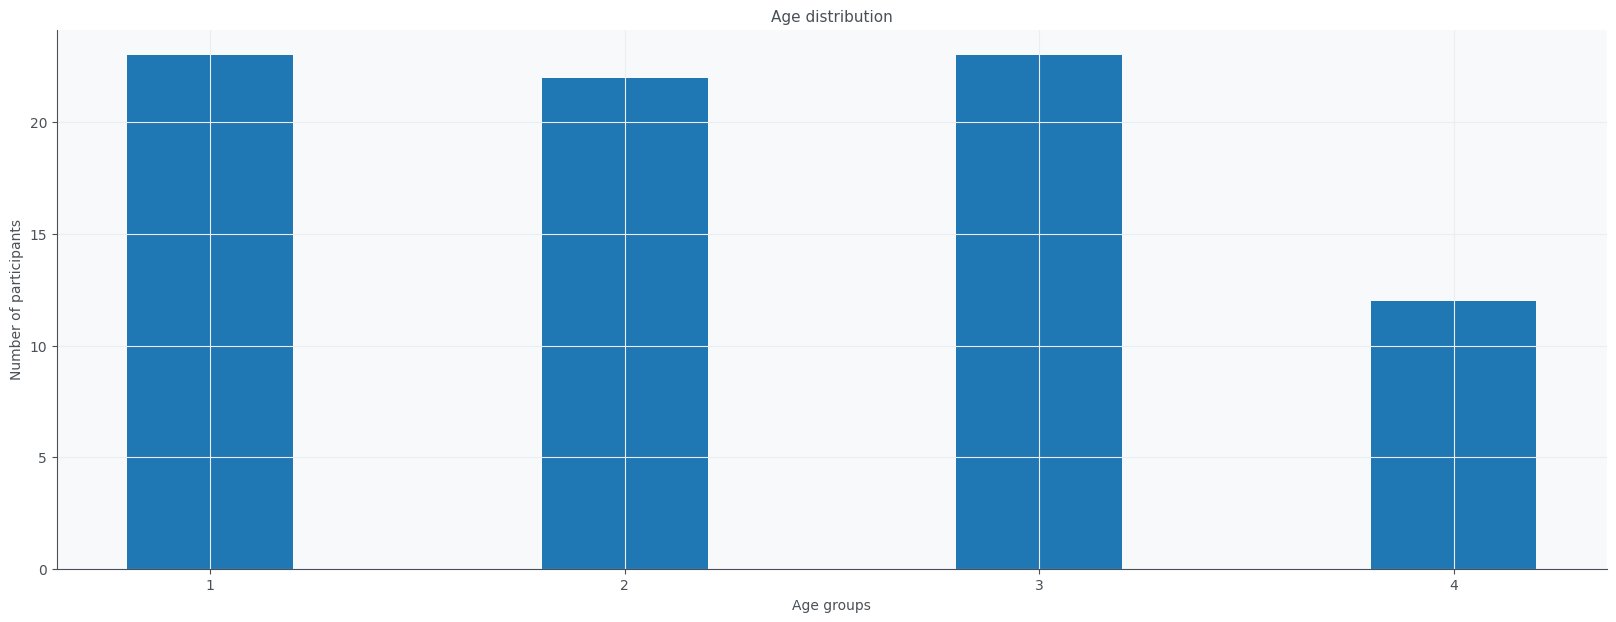

In [4]:
%matplotlib inline
# Plot age distribution

plt.figure(figsize=(20,7))
plt.title("Age distribution")
plt.xlabel("Age groups")
plt.ylabel("Number of participants")

labels, counts = np.unique(HRV_DF.AGE, return_counts=True)
plt.bar(labels, counts, width= 0.4, align='center')
plt.gca().set_xticks(labels)
plt.show()

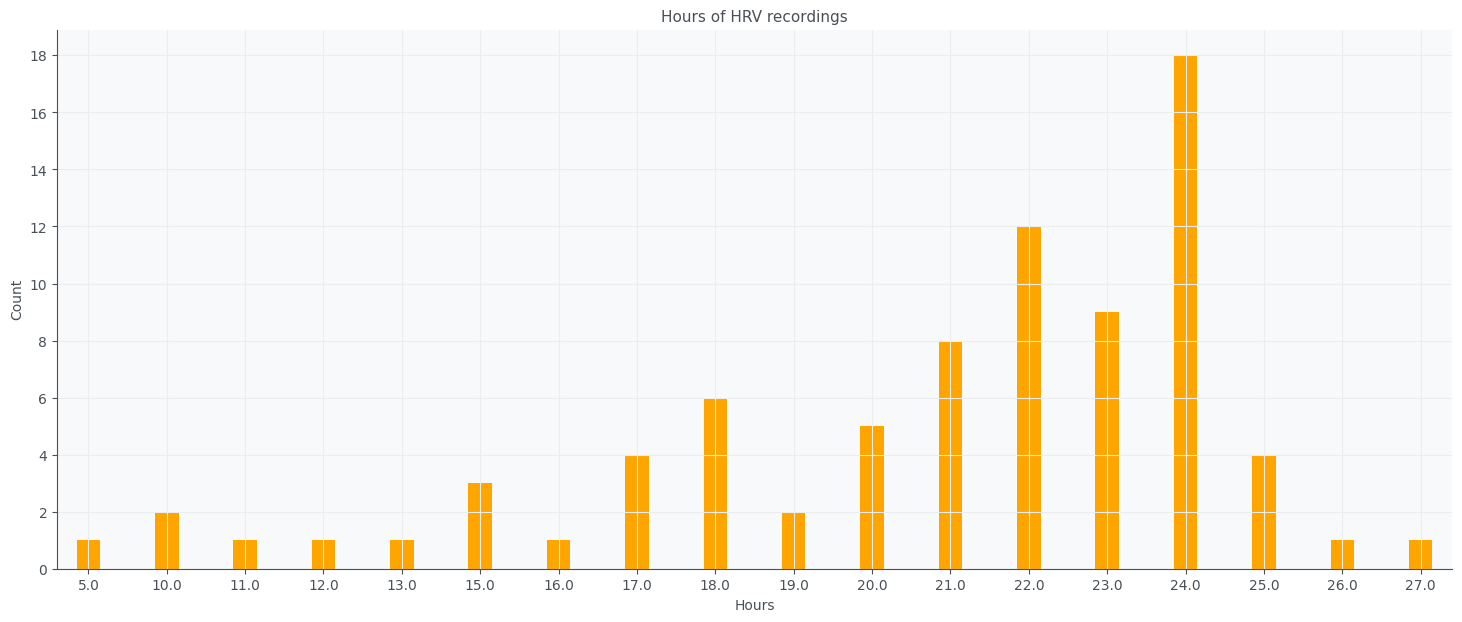

In [5]:
# Plot number of hours of HRV recordings

plt.figure(figsize=(18,7))
plt.title("Hours of HRV recordings")
plt.xlabel("Hours")
plt.ylabel("Count")
#plt.axis([5, 28, 0, 20])
plt.locator_params(axis="both", integer=True, nbins= 10)
HRV_DF.HRV_HOURS.value_counts().sort_index().plot(kind="bar", rot=0, width=0.3, color="orange")

plt.show()

Plotting HRV recording hours 

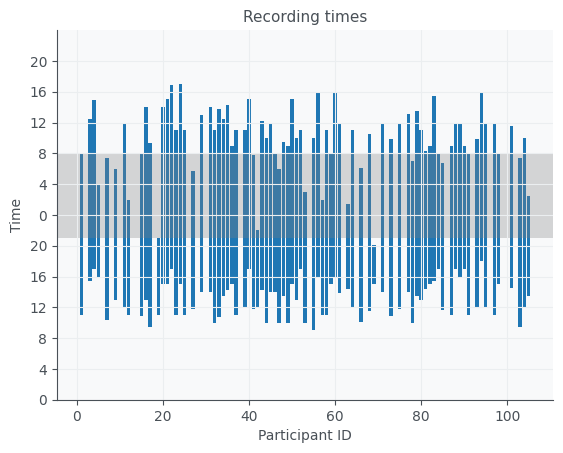

In [6]:
# Plotting HRV recording hours

ax = plt.bar(HRV_DF.ID, HRV_DF.HRV_HOURS, bottom=HRV_DF.HRV_TIME_float, label= "HRV recording hours")
plt.ylim(bottom=0, top=48)
plt.yticks(range(0, 48, 4), labels=list(range(0,24,4)) + list(range(0,24,4)))

plt.axhspan(21, 21+3+8, facecolor='grey', alpha=0.3)
plt.xlabel("Participant ID")
plt.ylabel("Time")
plt.title("Recording times")
plt.savefig('Recording_times.png')

plt.show()


Time domain analysis of HRV data

In [7]:
# Load HRV data

#HRV_1 = pd.read_csv("hyperaktiv/hrv_data/patient_hr_1.csv", sep=";")

# The code below is for setting Timestamp column as index
HRV_1 = pd.read_csv("hyperaktiv/hrv_data/patient_hr_1.csv", sep=";", parse_dates=['TIMESTAMP'], index_col=['TIMESTAMP'])

HRV_1.head()

,HRV
TIMESTAMP,
2009-03-04 11:00:00.000,2294.92
2009-03-04 11:00:02.295,631.84
2009-03-04 11:00:02.927,624.02
2009-03-04 11:00:03.551,636.72
2009-03-04 11:00:04.188,625.98


In [8]:
HRV_1.index

DatetimeIndex([       '2009-03-04 11:00:00', '2009-03-04 11:00:02.295000',
               '2009-03-04 11:00:02.927000', '2009-03-04 11:00:03.551000',
               '2009-03-04 11:00:04.188000', '2009-03-04 11:00:04.813000',
               '2009-03-04 11:00:05.446000', '2009-03-04 11:00:06.097000',
               '2009-03-04 11:00:06.753000', '2009-03-04 11:00:07.409000',
               ...
               '2009-03-05 08:07:27.530000', '2009-03-05 08:07:28.193000',
               '2009-03-05 08:07:28.864000', '2009-03-05 08:07:29.540000',
               '2009-03-05 08:07:30.230000', '2009-03-05 08:07:30.918000',
               '2009-03-05 08:07:31.590000', '2009-03-05 08:07:32.260000',
               '2009-03-05 08:07:32.931000', '2009-03-05 08:07:33.593000'],
              dtype='datetime64[ns]', name='TIMESTAMP', length=107474, freq=None)

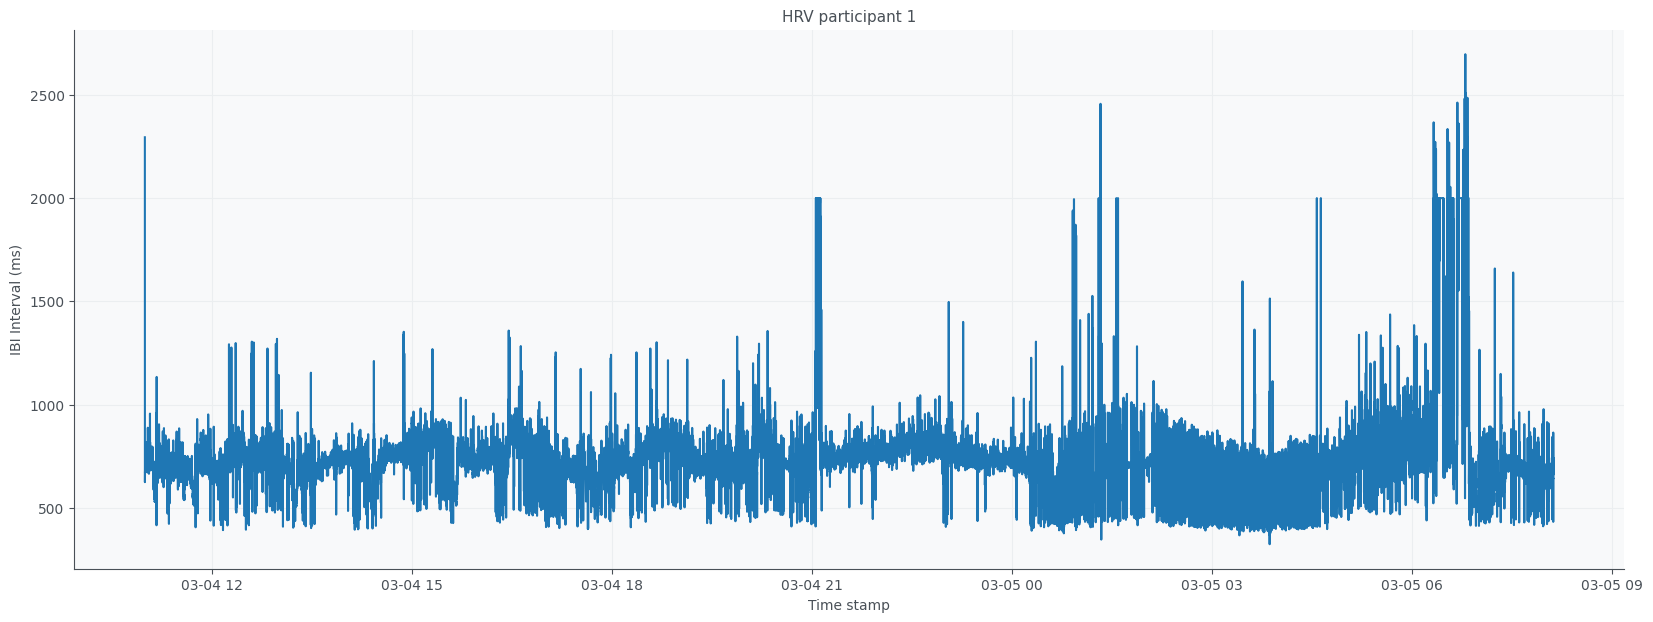

In [9]:
# Plot the HRV values and the timestamps.

plt.figure(figsize=(20, 7))
plt.title("HRV participant 1")
plt.xlabel("Time stamp")
plt.ylabel("IBI Interval (ms)")

plt.plot(HRV_1.HRV)
plt.show()

Dropping all data between 21:00 - 08:00


In [10]:
# Dropping all data between 21:00 - 08:00 for participant 1

HRV_1 = HRV_1[(HRV_1.index.hour >= 8) & (HRV_1.index.hour <= 20)]

print(HRV_1)

                             HRV
TIMESTAMP                       
2009-03-04 11:00:00.000  2294.92
2009-03-04 11:00:02.295   631.84
2009-03-04 11:00:02.927   624.02
2009-03-04 11:00:03.551   636.72
2009-03-04 11:00:04.188   625.98
...                          ...
2009-03-05 08:07:30.918   671.88
2009-03-05 08:07:31.590   669.92
2009-03-05 08:07:32.260   670.90
2009-03-05 08:07:32.931   662.11
2009-03-05 08:07:33.593   672.85

[51261 rows x 1 columns]


Replace outliers using interpolation - everything below 300ms and above 1300 ms

Trying for one participant first and plotting to see how well it worked.

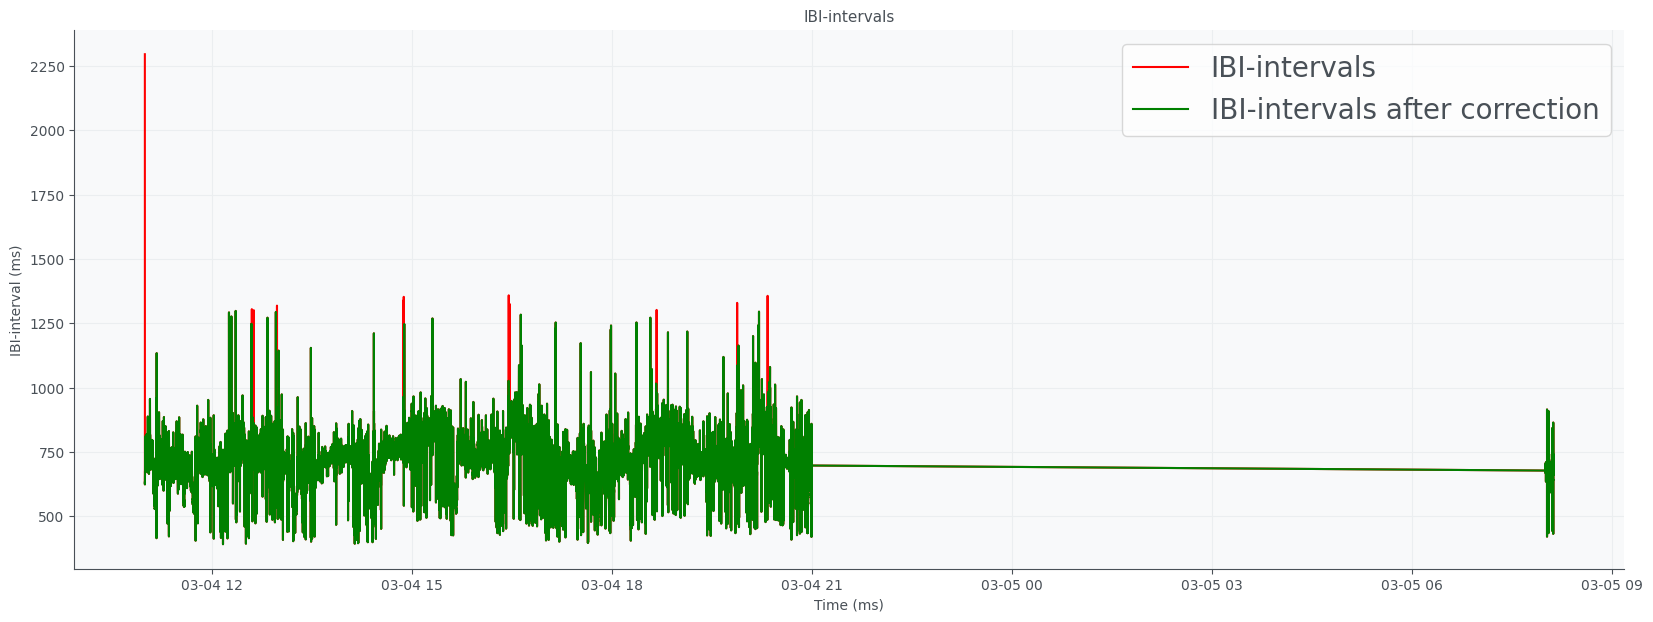

In [11]:
# For plotting, create a copy of the original HRV column and call it raw - it gets to keep the outliers
HRV_1_raw = HRV_1.HRV

# Turn every value below 300ms and above 1300ms to NaN
HRV_1['HRV'] = np.where((300 <= HRV_1['HRV']) & (HRV_1['HRV'] <= 1300), HRV_1['HRV'], np.nan)

# Fill NaN with interpolated value
HRV_1_cor = HRV_1['HRV'].interpolate(method='linear', axis=0).ffill().bfill()

plt.figure(figsize=(20, 7))

plt.title("IBI-intervals")
plt.xlabel("Time (ms)")
plt.ylabel("IBI-interval (ms)")

plt.plot(HRV_1_raw, color="red", label="IBI-intervals")
plt.plot(HRV_1_cor, color="green",  label="IBI-intervals after correction")
plt.legend(fontsize = "20")
plt.show()

In [12]:
# Time domain analysis of Participant 1

def timedomain(HRV_1_cor):
    results = {}

    hr = 60000/HRV_1_cor #Divide number of miliseconds in a whole minute with the IBI to find how many beats occur in one minute (BPM)
    
    results['Mean IBI (ms)'] = np.mean(HRV_1_cor)
    results['SDNN (STD IBI) (ms)'] = np.std(HRV_1_cor)  # I want SDANN + SDNN index
    results['Mean HR (Kubios\' style) (beats/min)'] = 60000/np.mean(HRV_1_cor)
    results['Mean HR (beats/min)'] = np.mean(hr)
    results['STD HR (beats/min)'] = np.std(hr)
    results['Min HR (beats/min)'] = np.min(hr)
    results['Max HR (beats/min)'] = np.max(hr)
    results['RMSSD (ms)'] = np.sqrt(np.mean(np.square(np.diff(HRV_1_cor))))
    results['NN50'] = np.sum(np.abs(np.diff(HRV_1_cor)) > 50)*1  
    results['pNN50 (%)'] = 100 * np.sum((np.abs(np.diff(HRV_1_cor)) > 50)*1) / len(HRV_1_cor) 
    return results


print("Time domain metrics - IBI-intervals:")
for k, v in timedomain(HRV_1_cor).items():
    print("- %s: %.2f" % (k, v))


print(" ")


Time domain metrics - IBI-intervals:
- Mean IBI (ms): 711.03
- SDNN (STD IBI) (ms): 82.16
- Mean HR (Kubios' style) (beats/min): 84.38
- Mean HR (beats/min): 85.57
- STD HR (beats/min): 10.44
- Min HR (beats/min): 46.23
- Max HR (beats/min): 153.22
- RMSSD (ms): 44.49
- NN50: 2133.00
- pNN50 (%): 4.16
 


In [13]:
# Calculate SDANN and SDNN Index

# SDANN
SDANN = HRV_1.resample('5T').std()
SDANN


,HRV
TIMESTAMP,
2009-03-04 11:00:00,40.777937
2009-03-04 11:05:00,80.410900
2009-03-04 11:10:00,70.544131
2009-03-04 11:15:00,48.572720
2009-03-04 11:20:00,42.948152
...,...
2009-03-05 07:45:00,NaN
2009-03-05 07:50:00,NaN
2009-03-05 07:55:00,NaN


In [14]:
# SDNN Index
SDNNI = SDANN.HRV.mean()
SDNNI

50.44460778521849

Create a function for time domain analysis

In [15]:
def timedomain(x):
    results = {}

    hr = 60000/x.HRV #Divide number of miliseconds in a whole minute with the IBI to find how many beats occur in one minute (BPM)
    
    results['Mean IBI'] = round(np.mean(x.HRV), 3)
    results['SDNN'] = round(np.std(x.HRV), 3) 
    SDANN = x.resample('5T').std() # SDANN has a value for every 5min section, so I will not include it in the output
    results['SDNN Index'] = round(SDANN.HRV.mean(), 3)
    results['Mean HR'] = round(60000/np.mean(x.HRV), 3)
    results['STD HR'] = round(np.std(hr), 3)
    results['Min HR'] = round(np.min(hr), 3)
    results['Max HR'] = round(np.max(hr), 3)
    results['RMSSD'] = round(np.sqrt(np.mean(np.square(np.diff(x.HRV)))), 3)
    results['NN50'] = np.sum(np.abs(np.diff(x.HRV)) > 50)*1
    results['pNN50'] = round(100 * np.sum((np.abs(np.diff(x.HRV)) > 50)*1) / len(x.HRV), 3)
    return results



Create a loop that removes everything between 08:00 and 21:00, replaces outliers with interpolated values, and runs time domain analysis on every participant file

In [16]:
# Create a list object 
HRV_data = []
sdnni = []

# Create list of datafiles

data_files = glob.glob("hyperaktiv/hrv_data/*.csv")

# For every file in the hrv_data folder:
for file in data_files:
    data = pd.read_csv(file, sep = ";", parse_dates=['TIMESTAMP'], index_col=['TIMESTAMP'])
    data = data[(data.index.hour >= 8) & (data.index.hour <= 20)]
    data['HRV'] = np.where((300 <= data['HRV']) & (data['HRV'] <= 1300), data['HRV'], np.nan)
    data['HRV'] = data['HRV'].interpolate(method='linear', axis=0).ffill().bfill()
    results = timedomain(data)
    HRV_data.append(results)




# Convert list to dataframe
HRV_df = pd.DataFrame(HRV_data)
# Print head of the dataframe
    
HRV_df.head()


,Mean IBI,SDNN,SDNN Index,Mean HR,STD HR,Min HR,Max HR,RMSSD,NN50,pNN50
0,711.032,82.162,50.455,84.384,10.443,46.230,153.218,44.494,2133,4.161
1,759.993,220.028,84.446,78.948,26.338,46.161,199.481,86.854,10657,21.935
2,634.521,125.293,56.302,94.560,17.988,46.195,198.834,47.913,2936,4.561
3,663.711,101.498,56.757,90.401,12.656,46.475,199.481,35.514,4202,6.917
4,596.728,95.721,43.125,100.548,15.360,46.161,199.481,45.602,1159,2.565


In [17]:
extract = HRV_DF[["ADHD", "AGE", "SEX", "HRV_HOURS"]]

extract = extract.reset_index(drop=True)
print(extract)

    ADHD  AGE  SEX  HRV_HOURS
0      1    3    0       21.0
1      1    2    1       21.0
2      1    3    1       22.0
3      1    1    1       12.0
4      0    3    0       21.0
..   ...  ...  ...        ...
75     1    3    0       17.0
76     0    1    1       21.0
77     0    4    1       22.0
78     0    2    0       22.0
79     0    4    1       13.0

[80 rows x 4 columns]


In [18]:
HRV_df = extract.join(HRV_df)

print(HRV_df)

    ADHD  AGE  SEX  HRV_HOURS  Mean IBI     SDNN  SDNN Index  Mean HR  STD HR  \
0      1    3    0       21.0   711.032   82.162      50.455   84.384  10.443   
1      1    2    1       21.0   759.993  220.028      84.446   78.948  26.338   
2      1    3    1       22.0   634.521  125.293      56.302   94.560  17.988   
3      1    1    1       12.0   663.711  101.498      56.757   90.401  12.656   
4      0    3    0       21.0   596.728   95.721      43.125  100.548  15.360   
..   ...  ...  ...        ...       ...      ...         ...      ...     ...   
75     1    3    0       17.0   646.780  118.448      67.822   92.767  18.337   
76     0    1    1       21.0   652.370  112.581      65.975   91.972  15.126   
77     0    4    1       22.0   696.243   97.593      54.397   86.177  12.553   
78     0    2    0       22.0   865.000  130.559      72.733   69.364  12.130   
79     0    4    1       13.0   634.715  144.764      91.009   94.531  20.374   

    Min HR   Max HR    RMSS

Visualize and compare the groups

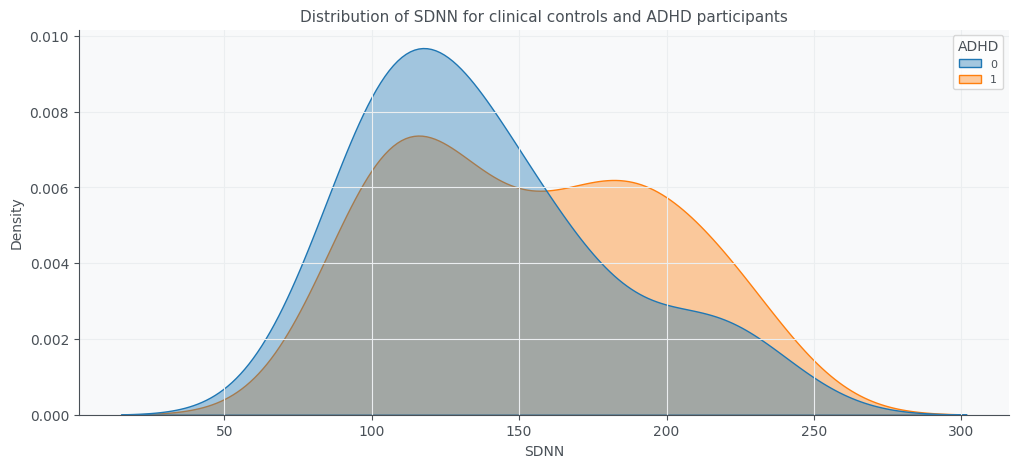

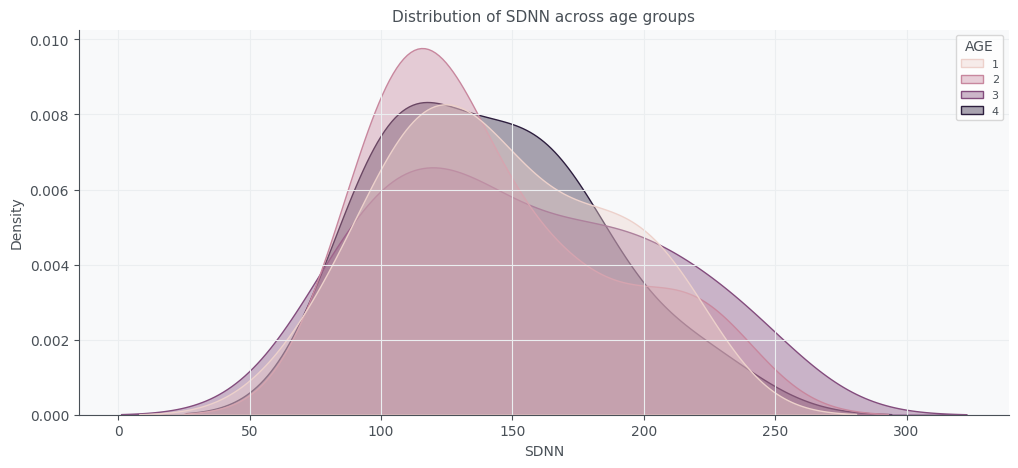

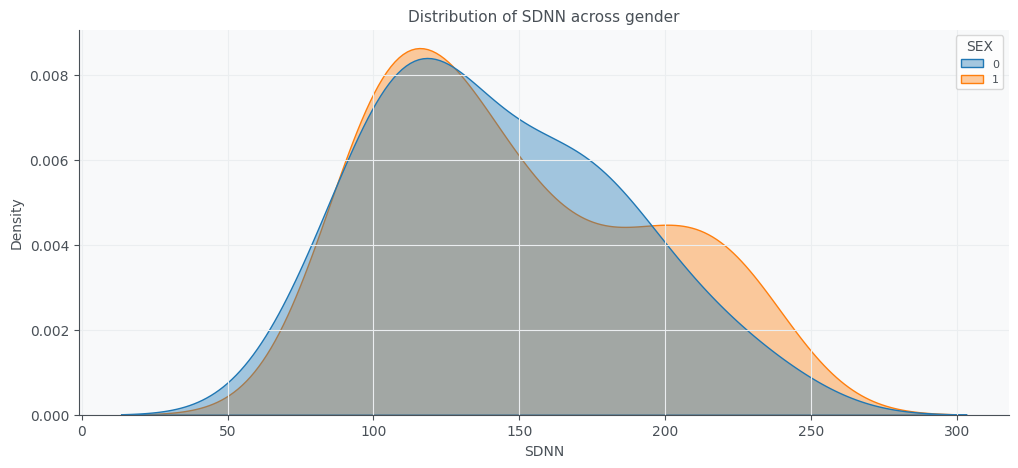

In [19]:
# Density plot 

# Set figure size for the notebook
plt.rcParams["figure.figsize"]=12,5


# ADHD vs clinical control
sns.kdeplot(data=HRV_df, x="SDNN", hue="ADHD", fill=True, common_norm=False, alpha=0.4)
plt.title('Distribution of SDNN for clinical controls and ADHD participants')
plt.show()

# Different age groups
sns.kdeplot(data=HRV_df, x="SDNN", hue="AGE", fill=True, common_norm=False, alpha=0.4)
plt.title('Distribution of SDNN across age groups')
plt.show()

# Gender 
sns.kdeplot(data=HRV_df, x="SDNN", hue="SEX", fill=True, common_norm=False, alpha=0.4)
plt.title('Distribution of SDNN across gender')
plt.show()



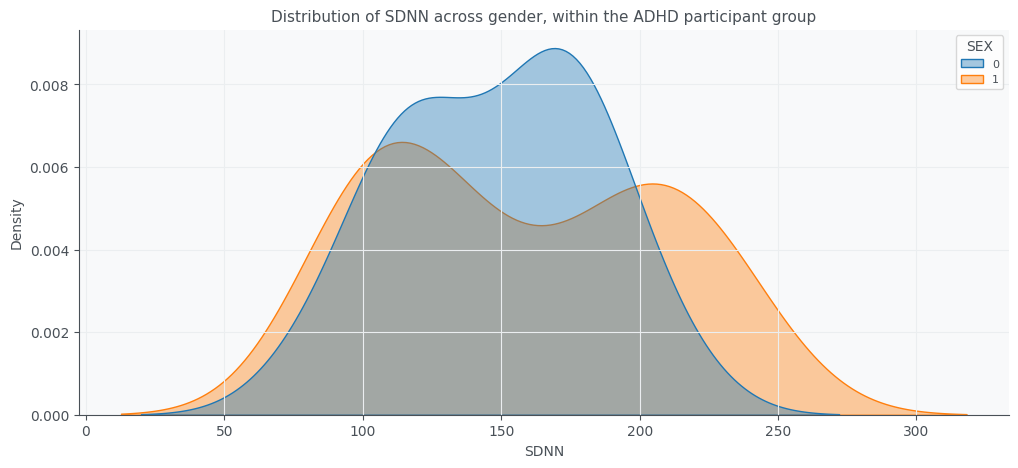

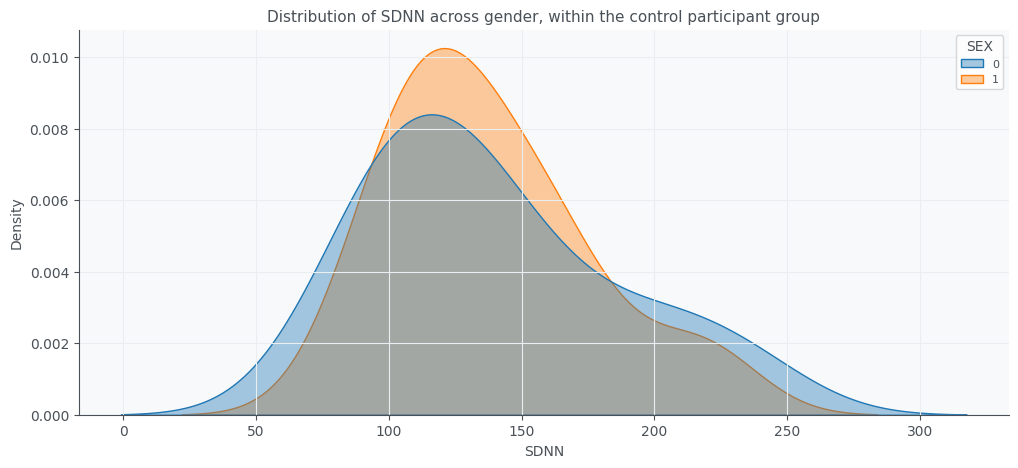

In [20]:
# ADHD participants seem to have a bimodal distribution. 

# Differences in gender on only adhd participant
adhd = HRV_df.loc[(HRV_df['ADHD']== 1)]

sns.kdeplot(data=adhd, x="SDNN", hue="SEX", fill=True, common_norm=False, alpha=0.4)
plt.title('Distribution of SDNN across gender, within the ADHD participant group')
plt.show()


# Differences in gender on only clinical controls
control = HRV_df.loc[(HRV_df['ADHD']== 0)]

sns.kdeplot(data=control, x="SDNN", hue="SEX", fill=True, common_norm=False, alpha=0.4)
plt.title('Distribution of SDNN across gender, within the control participant group')
plt.show()




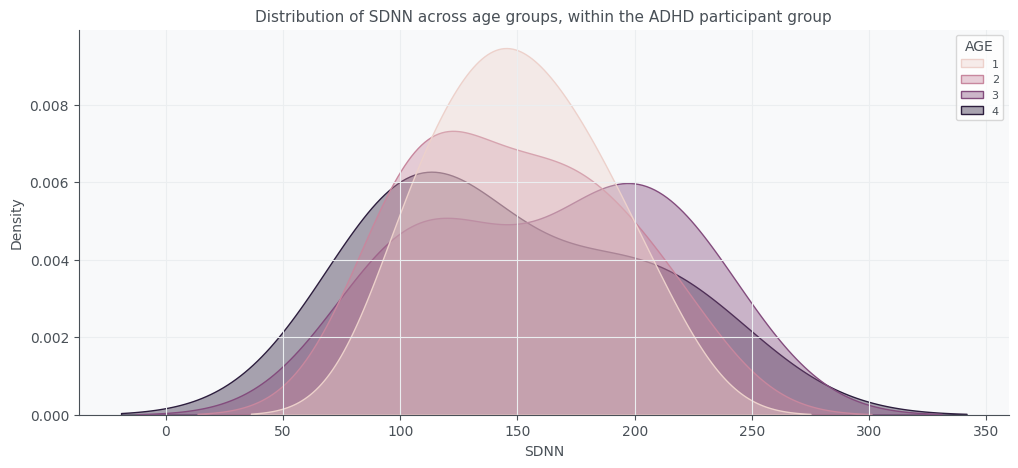

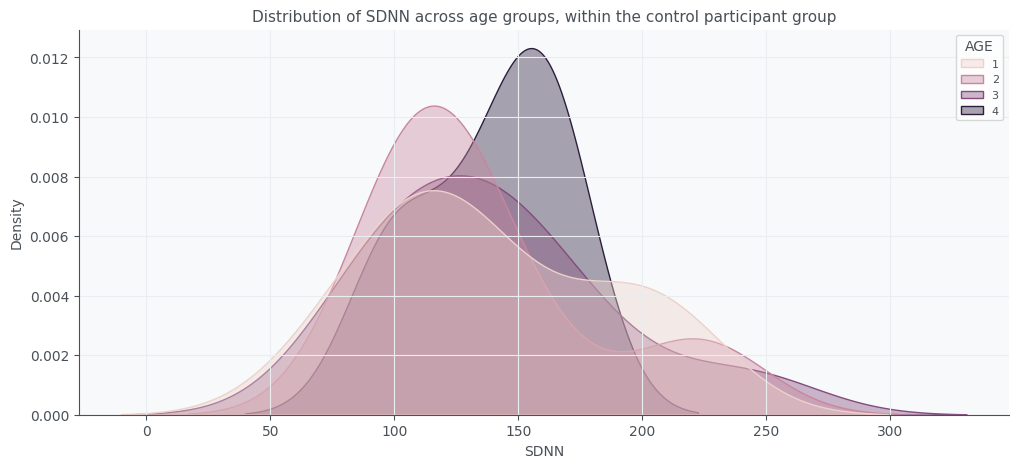

In [21]:
# ADHD - age groups 
sns.kdeplot(data=adhd, x="SDNN", hue="AGE", fill=True, common_norm=False, alpha=0.4)
plt.title('Distribution of SDNN across age groups, within the ADHD participant group')
plt.show()

# Control - age groups
sns.kdeplot(data=control, x="SDNN", hue="AGE", fill=True, common_norm=False, alpha=0.4)
plt.title('Distribution of SDNN across age groups, within the control participant group')
plt.show()

Making some scatterplots to investigate the bimodality of some of the plots

<AxesSubplot: xlabel='SDNN', ylabel='HRV_HOURS'>

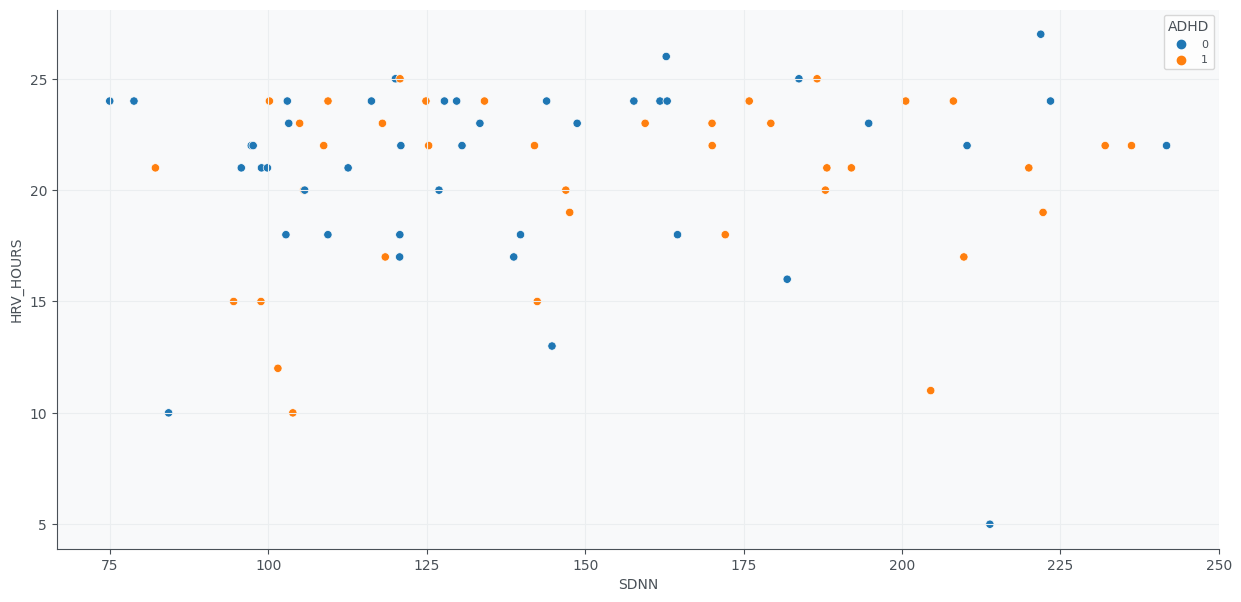

In [22]:
# Scatterplot. SDNN on x-axis, HRV_HOURS on y-axis
fig, ax = plt.subplots(figsize=(15, 7))

sns.scatterplot(x=HRV_df['SDNN'], y=HRV_df['HRV_HOURS'], hue=HRV_df['ADHD'], legend='full', ax=ax)


<AxesSubplot: xlabel='SDNN', ylabel='HRV_HOURS'>

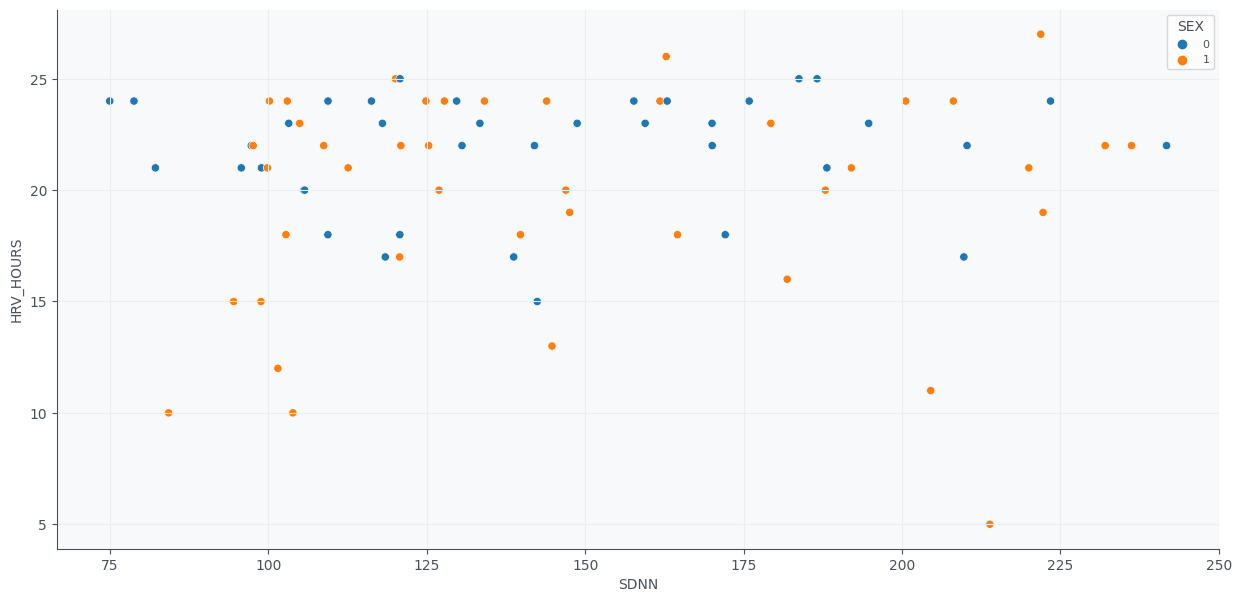

In [23]:
# Scatterplot. SDNN on x-axis, HRV_HOURS on y-axis
fig, ax = plt.subplots(figsize=(15, 7))

sns.scatterplot(x=HRV_df['SDNN'], y=HRV_df['HRV_HOURS'], hue=HRV_df['SEX'], legend='full', ax=ax)

<AxesSubplot: xlabel='SDNN', ylabel='HRV_HOURS'>

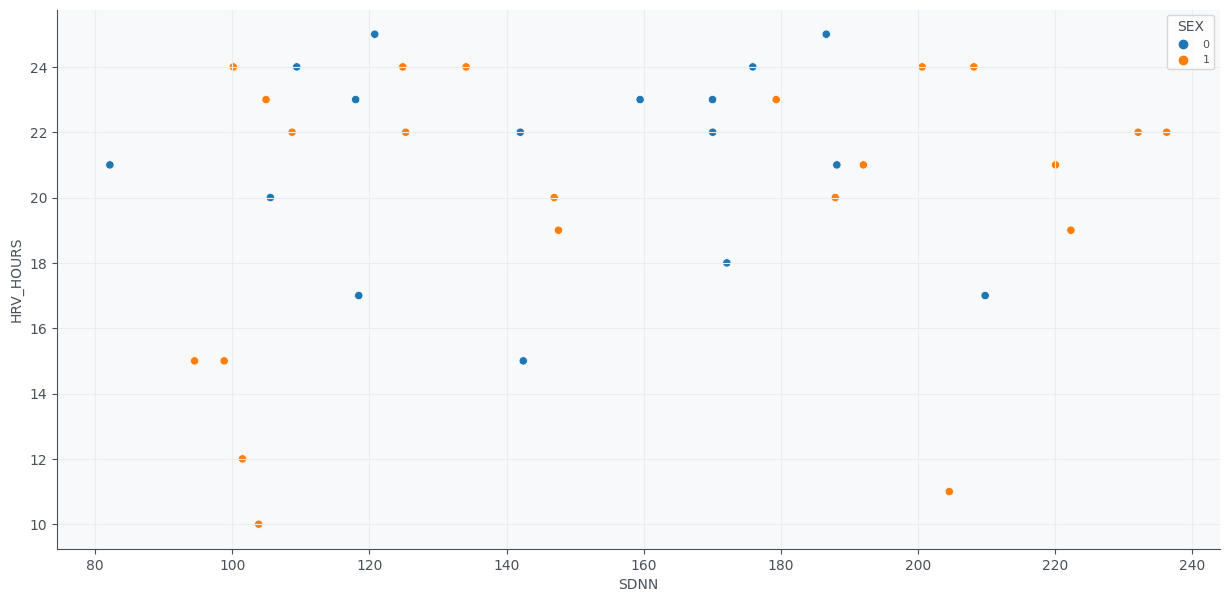

In [24]:
# Scatterplot. SDNN on x-axis, HRV_HOURS on y-axis
fig, ax = plt.subplots(figsize=(15, 7))

sns.scatterplot(x=adhd['SDNN'], y=adhd['HRV_HOURS'], hue=adhd['SEX'], legend='full', ax=ax)

<AxesSubplot: xlabel='SDNN', ylabel='HRV_HOURS'>

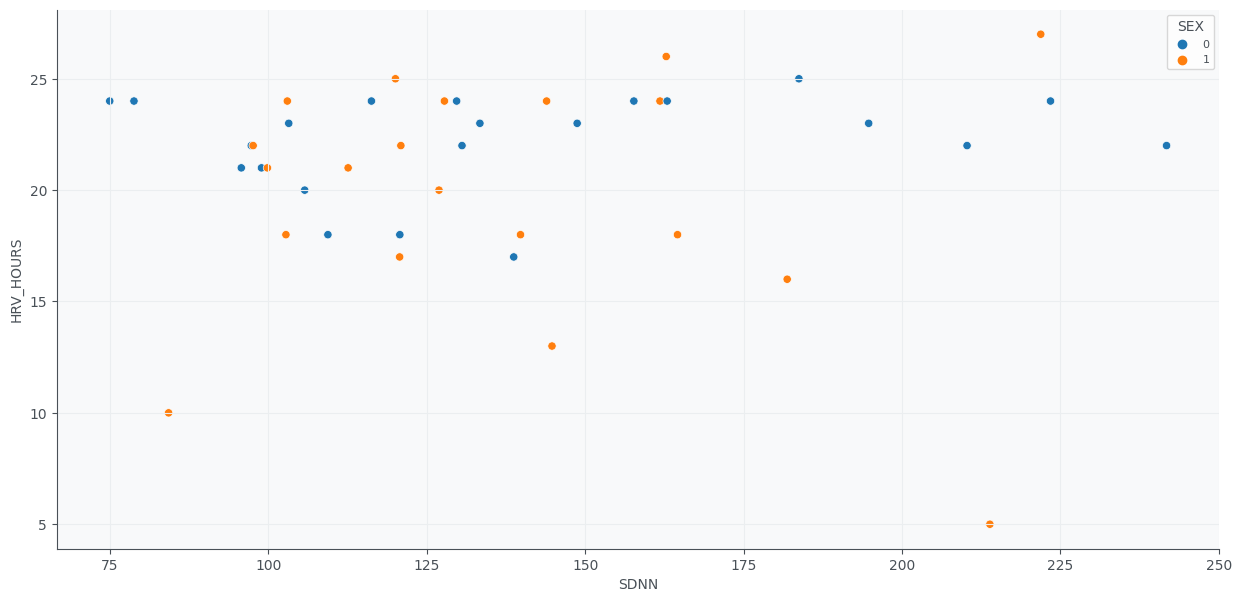

In [25]:
# Scatterplot. SDNN on x-axis, HRV_HOURS on y-axis
fig, ax = plt.subplots(figsize=(15, 7))

sns.scatterplot(x=control['SDNN'], y=control['HRV_HOURS'], hue=control['SEX'], legend='full', ax=ax)


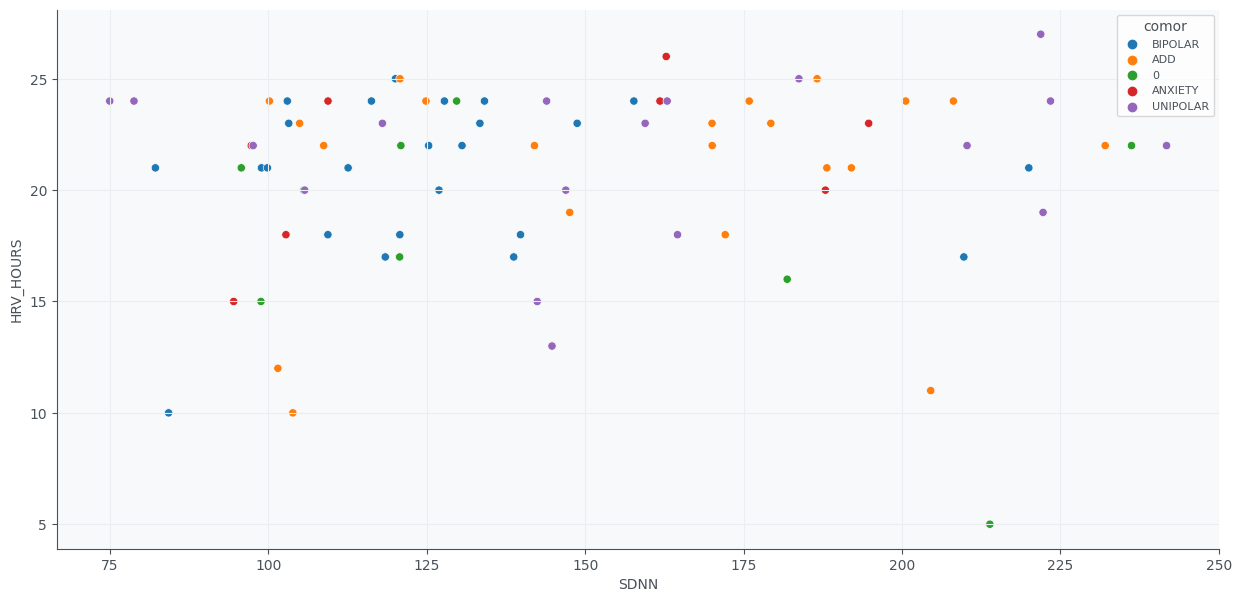

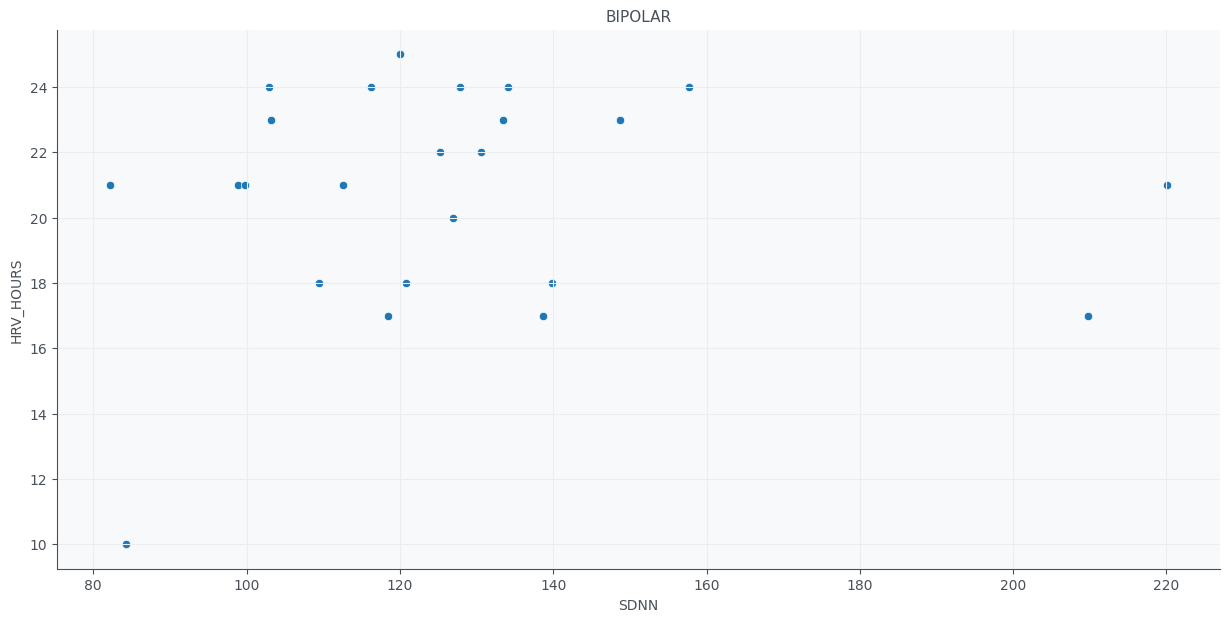

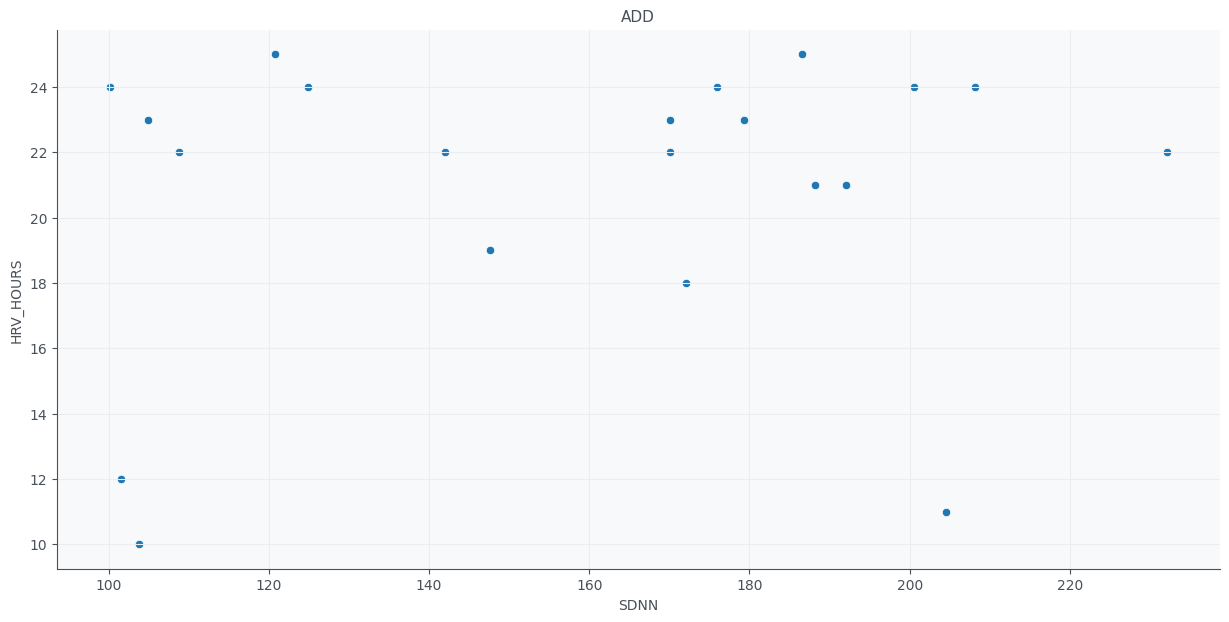

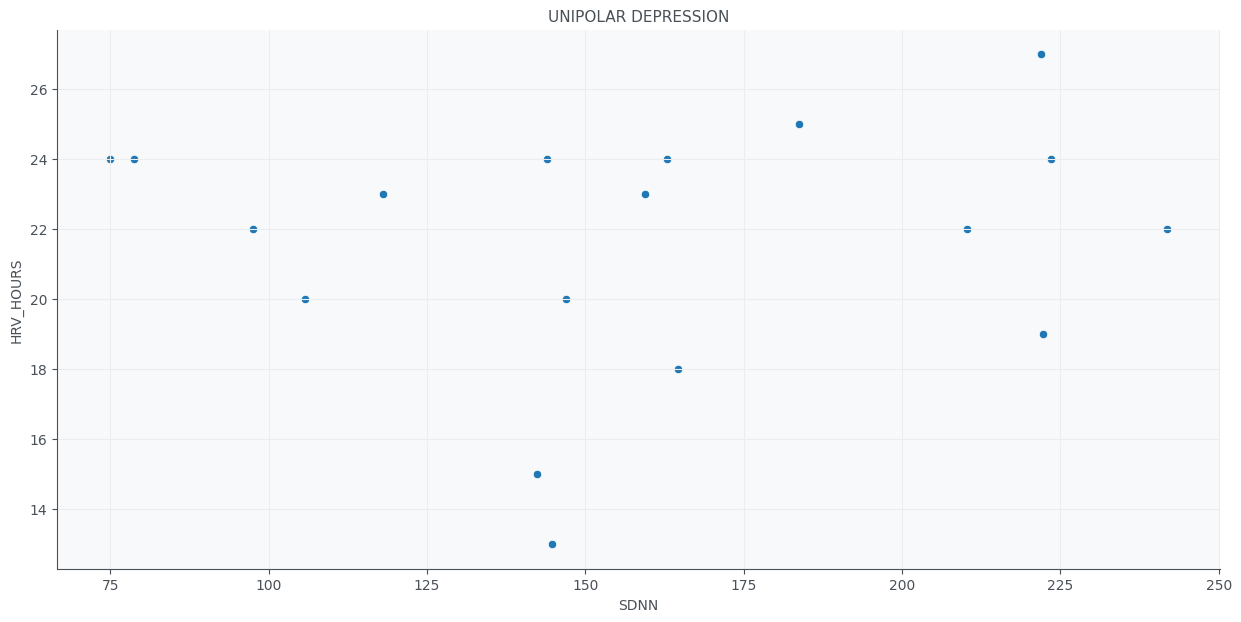

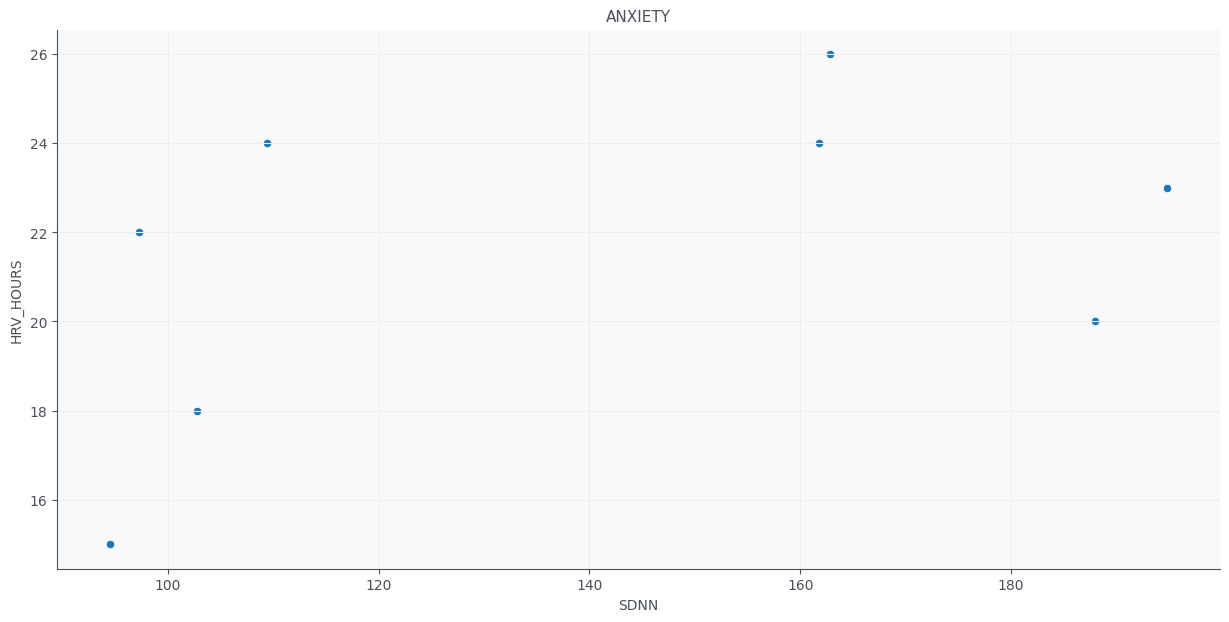

In [26]:
# Try to plot comorbidities.
patient_info = patient_info[patient_info['HRV']==1]
patient_info = patient_info[["ID", "SEX", "AGE", "ADHD", "HRV", "HRV_TIME", "HRV_HOURS", "ADD", "BIPOLAR", "UNIPOLAR", "ANXIETY"]]

conditions = [
    (patient_info["ADD"] == 1),
    (patient_info["BIPOLAR"] == 1),
    (patient_info["UNIPOLAR"] == 1),
    (patient_info["ANXIETY"] == 1)
]

co = ["ADD", "BIPOLAR", "UNIPOLAR", "ANXIETY"]

HRV_df["comor"] = np.select(conditions, co)

# Scatterplot. SDNN on x-axis, HRV_HOURS on y-axis
fig, ax = plt.subplots(figsize=(15, 7))

sns.scatterplot(x=HRV_df['SDNN'], y=HRV_df['HRV_HOURS'], hue=HRV_df['comor'], legend='full', ax=ax)
plt.show()


bip = HRV_df.loc[(HRV_df["comor"] == "BIPOLAR")]
fig, ax = plt.subplots(figsize=(15, 7))
sns.scatterplot(x=bip['SDNN'], y=bip['HRV_HOURS'], legend='full', ax=ax)
plt.title("BIPOLAR")
plt.show()


add = HRV_df.loc[(HRV_df["comor"] == "ADD")]
fig, ax = plt.subplots(figsize=(15, 7))
sns.scatterplot(x=add['SDNN'], y=add['HRV_HOURS'], legend='full', ax=ax)
plt.title("ADD")
plt.show()

uni = HRV_df.loc[(HRV_df["comor"] == "UNIPOLAR")]
fig, ax = plt.subplots(figsize=(15, 7))
sns.scatterplot(x=uni['SDNN'], y=uni['HRV_HOURS'], legend='full', ax=ax)
plt.title("UNIPOLAR DEPRESSION")
plt.show()

anx = HRV_df.loc[(HRV_df["comor"] == "ANXIETY")]
fig, ax = plt.subplots(figsize=(15, 7))
sns.scatterplot(x=anx['SDNN'], y=anx['HRV_HOURS'], legend='full', ax=ax)
plt.title("ANXIETY")
plt.show()



Linear regression models

In [27]:
# I will be focusing on SDNN, RMSSD, and pNN50 
# I will make two models for each metric

# Models with only participant group as predictor
model1s = smf.ols(formula="SDNN ~ ADHD", data = HRV_df).fit()
print(model1s.summary())

model1r = smf.ols(formula= "RMSSD ~ ADHD", data = HRV_df).fit()
print(model1r.summary())

model1p = smf.ols(formula= "pNN50 ~ ADHD", data = HRV_df).fit()
print(model1p.summary())


# Models with sex and age included as predictors (interaction because they are interacting with each other)
model2s = smf.ols(formula="SDNN ~ ADHD + SEX + AGE + ADHD:SEX + ADHD:AGE + SEX:AGE", data = HRV_df).fit()
print(model2s.summary())

model2r = smf.ols(formula="RMSSD ~ ADHD + SEX + AGE + ADHD:SEX + ADHD:AGE + SEX:AGE", data = HRV_df).fit()
print(model2s.summary())

model2p = smf.ols(formula="pNN50 ~ ADHD + SEX + AGE + ADHD:SEX + ADHD:AGE + SEX:AGE", data = HRV_df).fit()
print(model2s.summary())




                            OLS Regression Results                            
Dep. Variable:                   SDNN   R-squared:                       0.032
Model:                            OLS   Adj. R-squared:                  0.019
Method:                 Least Squares   F-statistic:                     2.545
Date:                Thu, 11 Apr 2024   Prob (F-statistic):              0.115
Time:                        14:41:17   Log-Likelihood:                -414.26
No. Observations:                  80   AIC:                             832.5
Df Residuals:                      78   BIC:                             837.3
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept    138.2969      6.707     20.620      0.0

Residuals and qq-plots

                            OLS Regression Results                            
Dep. Variable:                   SDNN   R-squared:                       0.032
Model:                            OLS   Adj. R-squared:                  0.019
Method:                 Least Squares   F-statistic:                     2.545
Date:                Thu, 11 Apr 2024   Prob (F-statistic):              0.115
Time:                        14:41:17   Log-Likelihood:                -414.26
No. Observations:                  80   AIC:                             832.5
Df Residuals:                      78   BIC:                             837.3
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept    138.2969      6.707     20.620      0.0

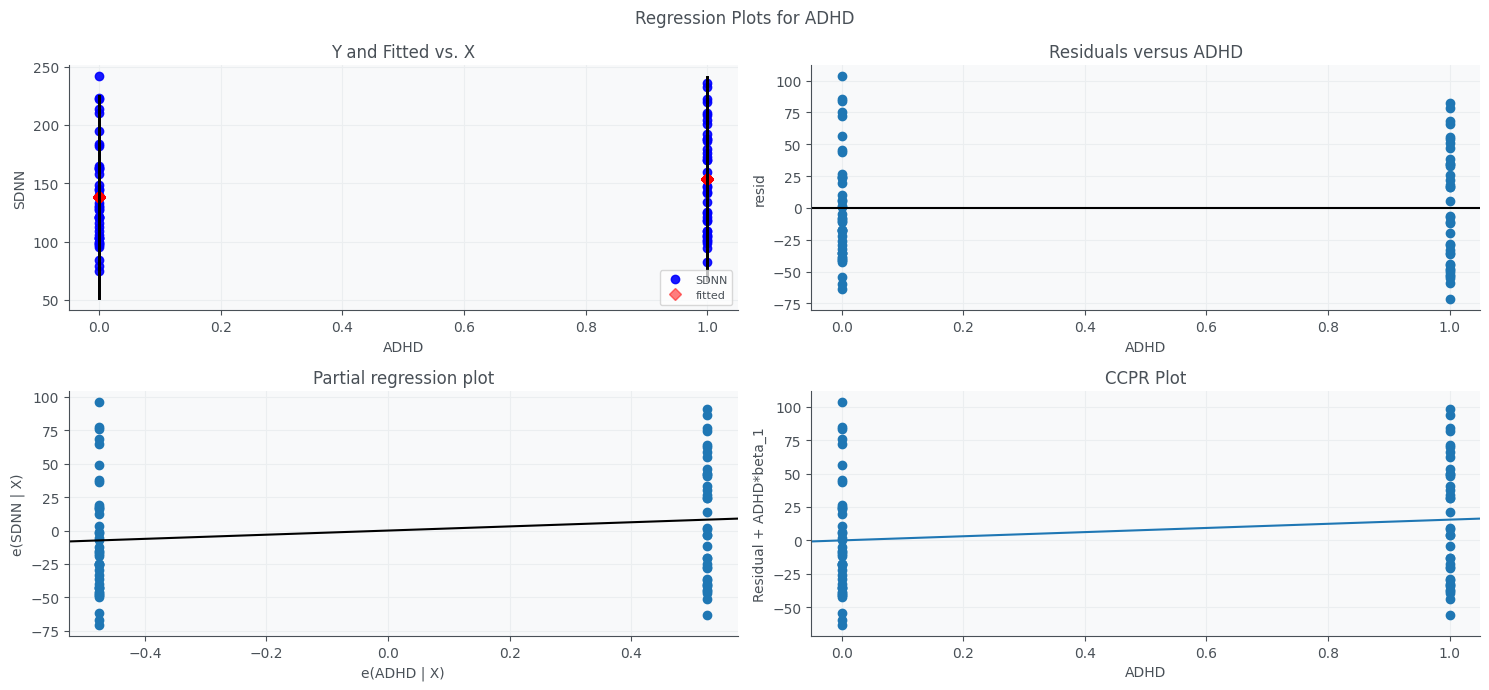

In [28]:
print(model1s.summary())

fig= plt.figure(figsize=(15,7))

fig = sm.graphics.plot_regress_exog(model1s, "ADHD", fig=fig)

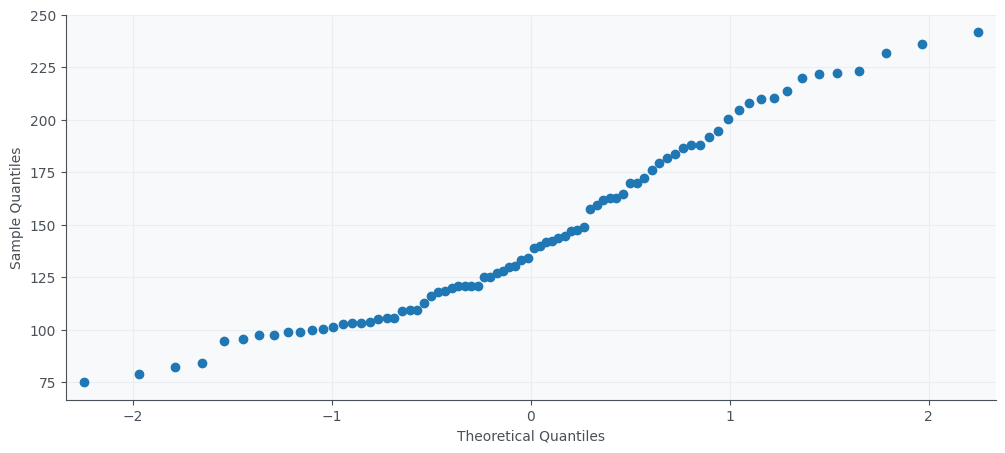

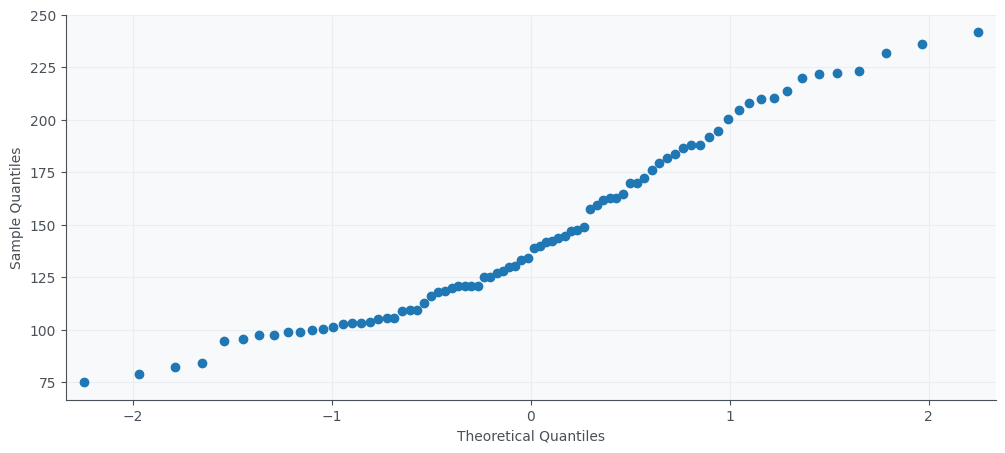

In [29]:
sm.qqplot(HRV_df["SDNN"])

Checking assumptions of homogeneity of variance before running t-tests.

Levene's test: 
If p-value is less than 0.05, we reject the null hypothesis, that Group 1 and Group 2 come from populations with equal variances.
If p-value is larger than 0.05, we do not reject the null hypothesis, that Group 1 and Group 2 come from populations with equal variances.

In [30]:
# Subset data
# ADHD - male vs female *
adhd_m = HRV_df.loc[(HRV_df['ADHD']== 1) & (HRV_df['SEX']== 1)]
adhd_f = HRV_df.loc[(HRV_df['ADHD']== 1) & (HRV_df['SEX']== 0)]

# Control - male vs female *
control_m = HRV_df.loc[(HRV_df['ADHD']== 0) & (HRV_df['SEX']== 1)]
control_f = HRV_df.loc[(HRV_df['ADHD']== 0) & (HRV_df['SEX']== 0)]

# All male vs female (regardless of participant group) *
male = HRV_df.loc[(HRV_df['SEX']== 1)]
female = HRV_df.loc[(HRV_df['SEX']== 0)]

# All Age groups *
age1 = HRV_df.loc[(HRV_df['AGE']== 1)]
age2 = HRV_df.loc[(HRV_df['AGE']== 2)]
age3 = HRV_df.loc[(HRV_df['AGE']== 3)]
age4 = HRV_df.loc[(HRV_df['AGE']== 4)]

# ADHD - age groups *
adhdage1 = HRV_df.loc[(HRV_df['AGE']== 1)&(HRV_df['ADHD']== 1)]
adhdage2 = HRV_df.loc[(HRV_df['AGE']== 2)&(HRV_df['ADHD']== 1)]
adhdage3 = HRV_df.loc[(HRV_df['AGE']== 3)&(HRV_df['ADHD']== 1)]
adhdage4 = HRV_df.loc[(HRV_df['AGE']== 4)&(HRV_df['ADHD']== 1)]

# Control - age groups *
controlage1 = HRV_df.loc[(HRV_df['AGE']== 1)&(HRV_df['ADHD']== 0)]
controlage2 = HRV_df.loc[(HRV_df['AGE']== 2)&(HRV_df['ADHD']== 0)]
controlage3 = HRV_df.loc[(HRV_df['AGE']== 3)&(HRV_df['ADHD']== 0)]
controlage4 = HRV_df.loc[(HRV_df['AGE']== 4)&(HRV_df['ADHD']== 0)]

Extra - levenes test and T-test

In [31]:
# Define a function that runs Levene's test for the last 10 columns in the dataframe

def lev(x, y, *args):
    test_results = {}

    test_results['Mean IBI'] = levene(x['Mean IBI'], y['Mean IBI'])
    test_results['SDNN'] = levene(x['SDNN'], y['SDNN'])
    test_results['SDNN Index'] = levene(x['SDNN Index'], y['SDNN Index'])
    test_results['Mean HR'] = levene(x['Mean HR'], y['Mean HR'])
    test_results['STD HR'] = levene(x['STD HR'], y['STD HR'])
    test_results['Min HR'] = levene(x['Min HR'], y['Min HR'])
    test_results['Max HR'] = levene(x['Max HR'], y['Max HR'])
    test_results['RMSSD'] = levene(x['RMSSD'], y['RMSSD'])
    test_results['NN50'] = levene(x['NN50'], y['NN50'])
    test_results['pNN50'] = levene(x['pNN50'], y['pNN50'])

    test_results = pd.DataFrame.from_dict(test_results)
    test_results.index = ["statistic", "P-value"]
    return test_results





In [32]:
aa = lev(adhd, control)
bb = lev(adhd_m, adhd_f)
cc = lev(control_m, control_f)
dd = lev(male, female)
ee = lev(age1, age2, age3, age4)
ff = lev(adhdage1, adhdage2, adhdage3, adhdage4)
gg = lev(controlage1, controlage2, controlage3, controlage4)

print(aa)
print(bb)
print(cc)
print(dd)
print(ee)
print(ff)
print(gg)


           Mean IBI      SDNN  SDNN Index   Mean HR    STD HR    Min HR  \
statistic  0.390977  1.208588    1.819228  0.087964  1.810781  0.352093   
P-value    0.533611  0.274993    0.181308  0.767570  0.182313  0.554648   

             Max HR     RMSSD      NN50     pNN50  
statistic  0.975029  1.896253  0.350756  0.998622  
P-value    0.326482  0.172438  0.555398  0.320734  
           Mean IBI      SDNN  SDNN Index   Mean HR    STD HR    Min HR  \
statistic  0.131803  3.970917    0.505335  0.331100  0.147030  0.121822   
P-value    0.718693  0.053916    0.481746  0.568591  0.703645  0.729100   

             Max HR     RMSSD      NN50     pNN50  
statistic  1.821049  2.375437  1.958340  1.265391  
P-value    0.185614  0.132002  0.170249  0.268078  
           Mean IBI      SDNN  SDNN Index   Mean HR    STD HR    Min HR  \
statistic  0.087941  0.730728    1.182470  0.009781  1.445755  0.504490   
P-value    0.768346  0.397739    0.283363  0.921712  0.236280  0.481655   

          

T-Tests to see whether there are significant differences between groups

In [33]:
# Define a function that runs T-test for the last 10 columns in the dataframe

def ttest(x, y):
    test_results = {}

    test_results['Mean IBI'] = stats.ttest_ind(x['Mean IBI'], y['Mean IBI'], equal_var=True)
    test_results['SDNN'] = stats.ttest_ind(x['SDNN'], y['SDNN'], equal_var=True)
    test_results['SDNN Index'] = stats.ttest_ind(x['SDNN Index'], y['SDNN Index'], equal_var=True)
    test_results['Mean HR'] = stats.ttest_ind(x['Mean HR'], y['Mean HR'], equal_var=True)
    test_results['STD HR'] = stats.ttest_ind(x['STD HR'], y['STD HR'], equal_var=True)
    test_results['Min HR'] = stats.ttest_ind(x['Min HR'], y['Min HR'], equal_var=True)
    test_results['Max HR'] = stats.ttest_ind(x['Max HR'], y['Max HR'], equal_var=True)
    test_results['RMSSD'] = stats.ttest_ind(x['RMSSD'], y['RMSSD'], equal_var=True)
    test_results['NN50'] = stats.ttest_ind(x['NN50'], y['NN50'], equal_var=True)
    test_results['pNN50'] = stats.ttest_ind(x['pNN50'], y['pNN50'], equal_var=True)

    test_results = pd.DataFrame.from_dict(test_results)
    test_results.index = ["T-score", "P-value"]
    return test_results



In [34]:
# T-test
a = ttest(adhd, control) # main hypothesis
b = ttest(control_m, control_f) # sanity check
c = ttest(adhd_m, adhd_f)
d = ttest(adhd_m, control_m)
e = ttest(adhd_f, control_f)

print(a)
print(b)
print(c)
print(d)
print(e)

         Mean IBI      SDNN  SDNN Index   Mean HR    STD HR    Min HR  \
T-score -0.853708  1.595443    1.258361  0.814522  1.648894 -0.436448   
P-value  0.395881  0.114657    0.212015  0.417826  0.103192  0.663717   

           Max HR     RMSSD      NN50     pNN50  
T-score  0.976115  0.802906  0.207976  0.449052  
P-value  0.332025  0.424469  0.835790  0.654639  
         Mean IBI      SDNN  SDNN Index   Mean HR    STD HR    Min HR  \
T-score  1.096413 -0.102683    1.141339 -0.992223 -0.874466  0.636376   
P-value  0.279455  0.918728    0.260516  0.327053  0.387085  0.528156   

           Max HR     RMSSD      NN50     pNN50  
T-score -2.170063  0.155879  0.202409  0.621116  
P-value  0.035998  0.876912  0.840623  0.538047  
         Mean IBI      SDNN  SDNN Index   Mean HR    STD HR    Min HR  \
T-score -0.816530  0.657128    0.184971  0.896888  0.238581  0.220997   
P-value  0.419568  0.515278    0.854290  0.375737  0.812783  0.826344   

           Max HR     RMSSD      NN50   

In [35]:
# Age groups and participant group * - (testing the relationship between -timedomain metric- age group and participant group)
# Subset columns I want to run anova on
age1s = age1[["Mean IBI", "SDNN", "SDNN Index", "Mean HR", "STD HR", "Min HR", "Max HR", "RMSSD", "NN50", "pNN50"]]
age2s = age2[["Mean IBI", "SDNN", "SDNN Index", "Mean HR", "STD HR", "Min HR", "Max HR", "RMSSD", "NN50", "pNN50"]]
age3s = age3[["Mean IBI", "SDNN", "SDNN Index", "Mean HR", "STD HR", "Min HR", "Max HR", "RMSSD", "NN50", "pNN50"]]
age4s = age4[["Mean IBI", "SDNN", "SDNN Index", "Mean HR", "STD HR", "Min HR", "Max HR", "RMSSD", "NN50", "pNN50"]]

print(f_oneway(age1s, age2s, age3s, age4s))

# ADHD - age groups * - two-way ANOVA (testing the relationship between -timedomain metric-, age group, and participant group)
aage1s = adhdage1[["Mean IBI", "SDNN", "SDNN Index", "Mean HR", "STD HR", "Min HR", "Max HR", "RMSSD", "NN50", "pNN50"]]
aage2s = adhdage2[["Mean IBI", "SDNN", "SDNN Index", "Mean HR", "STD HR", "Min HR", "Max HR", "RMSSD", "NN50", "pNN50"]]
aage3s = adhdage3[["Mean IBI", "SDNN", "SDNN Index", "Mean HR", "STD HR", "Min HR", "Max HR", "RMSSD", "NN50", "pNN50"]]
aage4s = adhdage4[["Mean IBI", "SDNN", "SDNN Index", "Mean HR", "STD HR", "Min HR", "Max HR", "RMSSD", "NN50", "pNN50"]]

print(f_oneway(aage1s, aage2s, aage3s, aage4s))

# Control - age groups * - same as above
cage1s = controlage1[["Mean IBI", "SDNN", "SDNN Index", "Mean HR", "STD HR", "Min HR", "Max HR", "RMSSD", "NN50", "pNN50"]]
cage2s = controlage2[["Mean IBI", "SDNN", "SDNN Index", "Mean HR", "STD HR", "Min HR", "Max HR", "RMSSD", "NN50", "pNN50"]]
cage3s = controlage3[["Mean IBI", "SDNN", "SDNN Index", "Mean HR", "STD HR", "Min HR", "Max HR", "RMSSD", "NN50", "pNN50"]]
cage4s = controlage4[["Mean IBI", "SDNN", "SDNN Index", "Mean HR", "STD HR", "Min HR", "Max HR", "RMSSD", "NN50", "pNN50"]]

print(f_oneway(cage1s, cage2s, cage3s, cage4s))


F_onewayResult(statistic=array([1.12832523, 0.29124958, 0.9118349 , 1.21894047, 0.75112064,
       0.20876901, 0.30941336, 0.66798615, 0.5626427 , 0.76201007]), pvalue=array([0.34302786, 0.83159044, 0.43938558, 0.30866757, 0.52506859,
       0.89003538, 0.81850949, 0.57429596, 0.64130893, 0.51886766]))
F_onewayResult(statistic=array([2.02470844, 0.25826643, 1.12234063, 2.25215318, 0.52436576,
       1.11006183, 0.50571326, 2.08316591, 1.19995563, 1.28435422]), pvalue=array([0.12889178, 0.85490949, 0.3536971 , 0.10002601, 0.66848248,
       0.35853105, 0.68094389, 0.12074446, 0.32453628, 0.29543323]))
F_onewayResult(statistic=array([0.76653833, 0.02098425, 0.15098826, 0.59192252, 0.14464012,
       0.94297384, 0.31373919, 0.38211596, 0.24619048, 0.16396013]), pvalue=array([0.51991046, 0.99580301, 0.92841576, 0.62411106, 0.9324822 ,
       0.42948195, 0.8153242 , 0.76644989, 0.86352271, 0.91997137]))


Frequency domain analysis

Frequency domain analysis function for participant 1, using pyhrv module

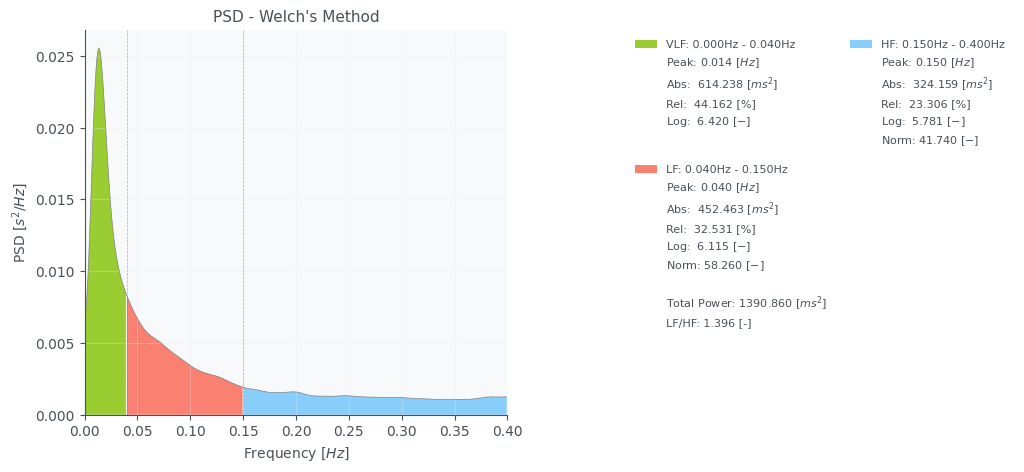

In [36]:
fre = frequency_domain.welch_psd(HRV_1_cor)


Frequency domain analysis, looping through all participants

In [37]:
# Supressing output plots so I don't create 80 plots during the loop
%matplotlib agg  
%matplotlib agg


In [38]:
# Create a list object 
Fre_data = []


# Create list of datafiles

data_filesf = glob.glob("hyperaktiv/hrv_data/*.csv")

# For every file in the hrv_data folder:
for file in data_filesf:
    data = pd.read_csv(file, sep = ";", parse_dates=['TIMESTAMP'], index_col=['TIMESTAMP'])
    data = data[(data.index.hour >= 8) & (data.index.hour <= 20)]
    data['HRV'] = np.where((300 <= data['HRV']) & (data['HRV'] <= 1300), data['HRV'], np.nan)
    data['HRV'] = data['HRV'].interpolate(method='linear', axis=0).ffill().bfill()
    results= frequency_domain.welch_psd(data["HRV"])
    Fre_data.append(results)




# Convert list to dataframe
Fre_df = pd.DataFrame(Fre_data)
# Print head of the dataframe
    
Fre_df.head()


c:\Users\Gacil\AppData\Local\Programs\Python\Python39\lib\site-packages\pyhrv\frequency_domain.py:950: UserWarning: Matplotlib is currently using agg, which is a non-GUI backend, so cannot show the figure.
  plt.show()
c:\Users\Gacil\AppData\Local\Programs\Python\Python39\lib\site-packages\pyhrv\frequency_domain.py:950: UserWarning: Matplotlib is currently using agg, which is a non-GUI backend, so cannot show the figure.
  plt.show()
c:\Users\Gacil\AppData\Local\Programs\Python\Python39\lib\site-packages\pyhrv\frequency_domain.py:950: UserWarning: Matplotlib is currently using agg, which is a non-GUI backend, so cannot show the figure.
  plt.show()
c:\Users\Gacil\AppData\Local\Programs\Python\Python39\lib\site-packages\pyhrv\frequency_domain.py:950: UserWarning: Matplotlib is currently using agg, which is a non-GUI backend, so cannot show the figure.
  plt.show()
c:\Users\Gacil\AppData\Local\Programs\Python\Python39\lib\site-packages\pyhrv\frequency_domain.py:950: UserWarning: Matplotl

,0,1,2,3,4,5,6,7,8,9,10,11,12
0,"(None, (0.0, 0.04), (0.04, 0.15), (0.15, 0.4))","(0.013671875, 0.0400390625, 0.150390625)","(614.2382657463203, 452.4627637354055, 324.158...","(44.162489369817095, 32.531157871488595, 23.30...","(6.420382907834723, 6.114705469666464, 5.78123...","(58.26040148341412, 41.73959851658588)",1.395806,1390.859697,Figure(1200x500),4096,hamming,4,cubic
1,"(None, (0.0, 0.04), (0.04, 0.15), (0.15, 0.4))","(0.0146484375, 0.0400390625, 0.2265625)","(2326.4810452174193, 1655.829497154426, 2195.0...","(37.66151201569002, 26.804878823840788, 35.533...","(7.752112123913203, 7.412057368988853, 7.69395...","(42.99892360332406, 57.00107639667595)",0.754353,6177.343714,Figure(1200x500),4096,hamming,4,cubic
2,"(None, (0.0, 0.04), (0.04, 0.15), (0.15, 0.4))","(0.0146484375, 0.0400390625, 0.150390625)","(983.0818941217292, 986.8053790565722, 683.006...","(37.05696230663947, 37.19731789827925, 25.7457...","(6.890692427075551, 6.894472835650248, 6.52650...","(59.096794913987715, 40.90320508601229)",1.444796,2652.893904,Figure(1200x500),4096,hamming,4,cubic
3,"(None, (0.0, 0.04), (0.04, 0.15), (0.15, 0.4))","(0.0146484375, 0.0400390625, 0.150390625)","(1034.7148339894147, 1107.768577979213, 454.96...","(39.83584045329313, 42.64836154074387, 17.5157...","(6.941881145020571, 7.010102980852273, 6.12021...","(70.88665720932232, 29.113342790677677)",2.434851,2597.446978,Figure(1200x500),4096,hamming,4,cubic
4,"(None, (0.0, 0.04), (0.04, 0.15), (0.15, 0.4))","(0.013671875, 0.0400390625, 0.2177734375)","(720.8100865148597, 527.0622282893318, 612.897...","(38.73718966194794, 28.324949779225715, 32.937...","(6.580375699696303, 6.26731862181585, 6.418198...","(46.23514596037441, 53.76485403962559)",0.859951,1860.770213,Figure(1200x500),4096,hamming,4,cubic


In [39]:
# Subset and add column names (looking at the frequency domain metrics output/plot for participant 1, as well as the documentation of the function, we can figure out which column is which)

Fre_df = Fre_df.iloc[:, [1, 2, 3, 4, 5, 6, 7]]

Fre_df.columns = ["VLFPeak", "VLFAbs", "VLFRel", "VLFLog", "LFNorm", "Ratio", "TotalPower"]

Fre_df.head()

,VLFPeak,VLFAbs,VLFRel,VLFLog,LFNorm,Ratio,TotalPower
0,"(0.013671875, 0.0400390625, 0.150390625)","(614.2382657463203, 452.4627637354055, 324.158...","(44.162489369817095, 32.531157871488595, 23.30...","(6.420382907834723, 6.114705469666464, 5.78123...","(58.26040148341412, 41.73959851658588)",1.395806,1390.859697
1,"(0.0146484375, 0.0400390625, 0.2265625)","(2326.4810452174193, 1655.829497154426, 2195.0...","(37.66151201569002, 26.804878823840788, 35.533...","(7.752112123913203, 7.412057368988853, 7.69395...","(42.99892360332406, 57.00107639667595)",0.754353,6177.343714
2,"(0.0146484375, 0.0400390625, 0.150390625)","(983.0818941217292, 986.8053790565722, 683.006...","(37.05696230663947, 37.19731789827925, 25.7457...","(6.890692427075551, 6.894472835650248, 6.52650...","(59.096794913987715, 40.90320508601229)",1.444796,2652.893904
3,"(0.0146484375, 0.0400390625, 0.150390625)","(1034.7148339894147, 1107.768577979213, 454.96...","(39.83584045329313, 42.64836154074387, 17.5157...","(6.941881145020571, 7.010102980852273, 6.12021...","(70.88665720932232, 29.113342790677677)",2.434851,2597.446978
4,"(0.013671875, 0.0400390625, 0.2177734375)","(720.8100865148597, 527.0622282893318, 612.897...","(38.73718966194794, 28.324949779225715, 32.937...","(6.580375699696303, 6.26731862181585, 6.418198...","(46.23514596037441, 53.76485403962559)",0.859951,1860.770213


In [40]:
# Split into separate columns for vlf, lf, hf

Fre_df[["VLFPeak", "LFPeak", "HFPeak"]] = Fre_df["VLFPeak"].astype("string").str.split(",", expand=True)
Fre_df[["VLFAbs", "LFAbs", "HFAbs"]] = Fre_df["VLFAbs"].astype("string").str.split(",", expand=True)
Fre_df[["VLFRel", "LFRel", "HFRel"]] = Fre_df["VLFRel"].astype("string").str.split(",", expand=True)
Fre_df[["VLFLog", "LFLog", "HFLog"]] = Fre_df["VLFLog"].astype("string").str.split(",", expand=True)
Fre_df[["LFNorm", "HFNorm"]] = Fre_df["LFNorm"].astype("string").str.split(",", expand=True)

In [41]:
Fre_df.head()

,VLFPeak,VLFAbs,VLFRel,VLFLog,LFNorm,Ratio,TotalPower,LFPeak,HFPeak,LFAbs,HFAbs,LFRel,HFRel,LFLog,HFLog,HFNorm
0,(0.013671875,(614.2382657463203,(44.162489369817095,(6.420382907834723,(58.26040148341412,1.395806,1390.859697,0.0400390625,0.150390625),452.4627637354055,324.1586673136321),32.531157871488595,23.306352758694302),6.114705469666464,5.781233109852559),41.73959851658588)
1,(0.0146484375,(2326.4810452174193,(37.66151201569002,(7.752112123913203,(42.99892360332406,0.754353,6177.343714,0.0400390625,0.2265625),1655.829497154426,2195.0331719436936),26.804878823840788,35.53360916046918),7.412057368988853,7.6939524378979005),57.00107639667595)
2,(0.0146484375,(983.0818941217292,(37.05696230663947,(6.890692427075551,(59.096794913987715,1.444796,2652.893904,0.0400390625,0.150390625),986.8053790565722,683.0066310411255),37.19731789827925,25.745719795081275),6.894472835650248,6.526504568222234),40.90320508601229)
3,(0.0146484375,(1034.7148339894147,(39.83584045329313,(6.941881145020571,(70.88665720932232,2.434851,2597.446978,0.0400390625,0.150390625),1107.768577979213,454.96356596723626),42.64836154074387,17.515798005963003),7.010102980852273,6.12021734094751),29.113342790677677)
4,(0.013671875,(720.8100865148597,(38.73718966194794,(6.580375699696303,(46.23514596037441,0.859951,1860.770213,0.0400390625,0.2177734375),527.0622282893318,612.8978980203109),28.324949779225715,32.93786055882635),6.26731862181585,6.418198360921946),53.76485403962559)


In [42]:
# Remove parenthesis from all dataframe cells
cols = ["VLFPeak", "VLFAbs", "VLFRel", "VLFLog", "LFNorm"]
ncols = ["HFPeak", "HFAbs", "HFRel", "HFLog", "HFNorm"]


Fre_df[cols] = Fre_df[cols].replace({"\(":" "}, regex = True)
Fre_df[ncols] = Fre_df[cols].replace({"\)":" "}, regex = True)

In [43]:
Fre_df.astype(float)

,VLFPeak,VLFAbs,VLFRel,VLFLog,LFNorm,Ratio,TotalPower,LFPeak,HFPeak,LFAbs,HFAbs,LFRel,HFRel,LFLog,HFLog,HFNorm
0,0.013672,614.238266,44.162489,6.420383,58.260401,1.395806,1390.859697,0.040039,0.013672,452.462764,614.238266,32.531158,44.162489,6.114705,6.420383,58.260401
1,0.014648,2326.481045,37.661512,7.752112,42.998924,0.754353,6177.343714,0.040039,0.014648,1655.829497,2326.481045,26.804879,37.661512,7.412057,7.752112,42.998924
2,0.014648,983.081894,37.056962,6.890692,59.096795,1.444796,2652.893904,0.040039,0.014648,986.805379,983.081894,37.197318,37.056962,6.894473,6.890692,59.096795
3,0.014648,1034.714834,39.835840,6.941881,70.886657,2.434851,2597.446978,0.040039,0.014648,1107.768578,1034.714834,42.648362,39.835840,7.010103,6.941881,70.886657
4,0.013672,720.810087,38.737190,6.580376,46.235146,0.859951,1860.770213,0.040039,0.013672,527.062228,720.810087,28.324950,38.737190,6.267319,6.580376,46.235146
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
75,0.014648,1384.028012,40.554124,7.232753,66.881297,2.019442,3412.792262,0.040039,0.014648,1356.863850,1384.028012,39.758173,40.554124,7.212931,7.232753,66.881297
76,0.014648,1073.130053,29.519083,6.978335,62.584664,1.672701,3635.377309,0.040039,0.014648,1603.573837,1073.130053,44.110245,29.519083,7.379990,6.978335,62.584664
77,0.013672,920.485802,41.979968,6.824902,77.559359,3.456201,2192.678650,0.040039,0.013672,986.704616,920.485802,44.999965,41.979968,6.894371,6.824902,77.559359
78,0.013672,1746.035548,56.425018,7.465103,67.439085,2.071167,3094.435077,0.040039,0.013672,909.348301,1746.035548,29.386569,56.425018,6.812728,7.465103,67.439085


In [44]:
# Add participant group, age and sex
extract = HRV_DF[["ADHD", "AGE", "SEX", "HRV_HOURS"]]

extract = extract.reset_index(drop=True)
print(extract)

Fre_df = extract.join(Fre_df)


    ADHD  AGE  SEX  HRV_HOURS
0      1    3    0       21.0
1      1    2    1       21.0
2      1    3    1       22.0
3      1    1    1       12.0
4      0    3    0       21.0
..   ...  ...  ...        ...
75     1    3    0       17.0
76     0    1    1       21.0
77     0    4    1       22.0
78     0    2    0       22.0
79     0    4    1       13.0

[80 rows x 4 columns]


In [45]:
Fre_df = Fre_df.astype(float)

In [46]:
Fre_df[["ADHD", "AGE", "SEX"]] = Fre_df[["ADHD", "AGE", "SEX"]].astype("category")
Fre_df["HRV_HOURS"] = Fre_df["HRV_HOURS"].astype(int)


In [47]:
Fre_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 80 entries, 0 to 79
Data columns (total 20 columns):
 #   Column      Non-Null Count  Dtype   
---  ------      --------------  -----   
 0   ADHD        80 non-null     category
 1   AGE         80 non-null     category
 2   SEX         80 non-null     category
 3   HRV_HOURS   80 non-null     int32   
 4   VLFPeak     80 non-null     float64 
 5   VLFAbs      80 non-null     float64 
 6   VLFRel      80 non-null     float64 
 7   VLFLog      80 non-null     float64 
 8   LFNorm      80 non-null     float64 
 9   Ratio       80 non-null     float64 
 10  TotalPower  80 non-null     float64 
 11  LFPeak      80 non-null     float64 
 12  HFPeak      80 non-null     float64 
 13  LFAbs       80 non-null     float64 
 14  HFAbs       80 non-null     float64 
 15  LFRel       80 non-null     float64 
 16  HFRel       80 non-null     float64 
 17  LFLog       80 non-null     float64 
 18  HFLog       80 non-null     float64 
 19  HFNorm    

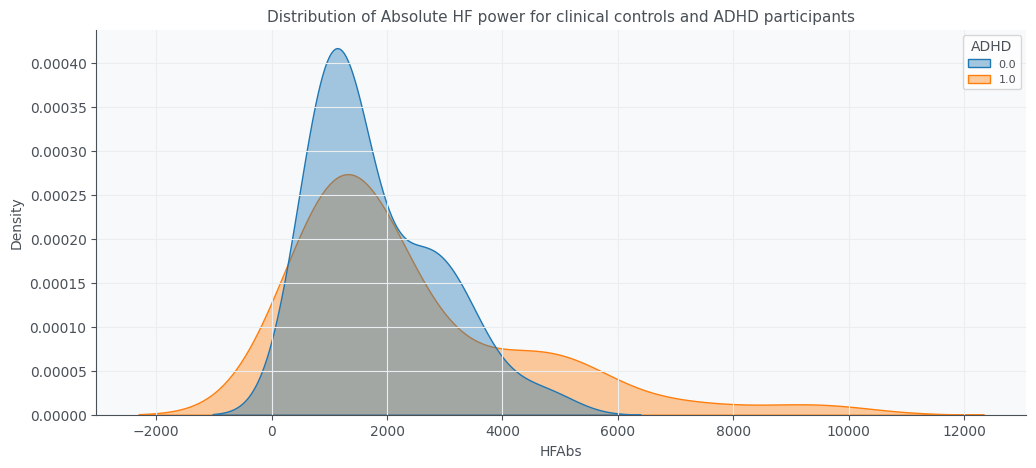

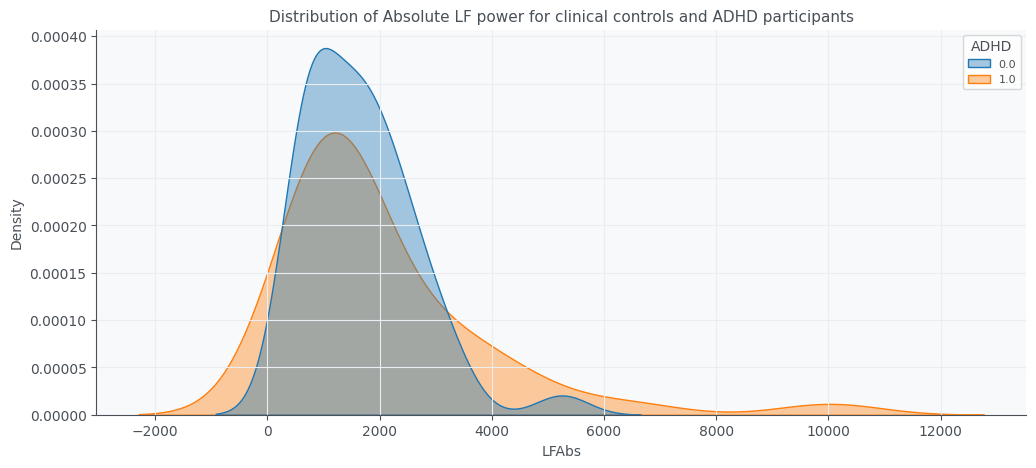

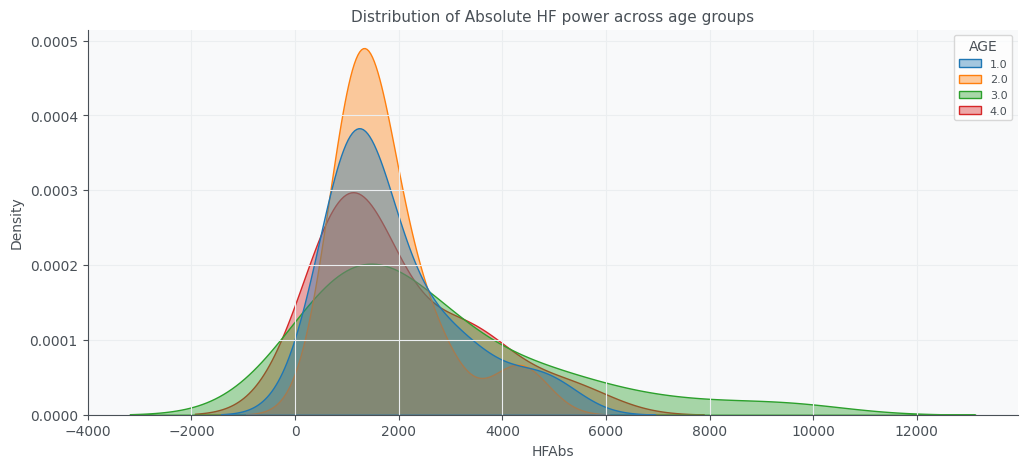

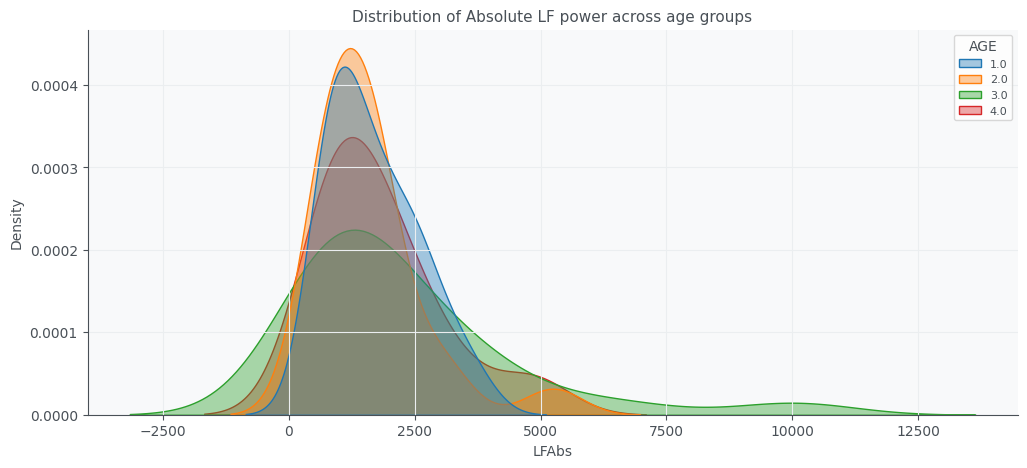

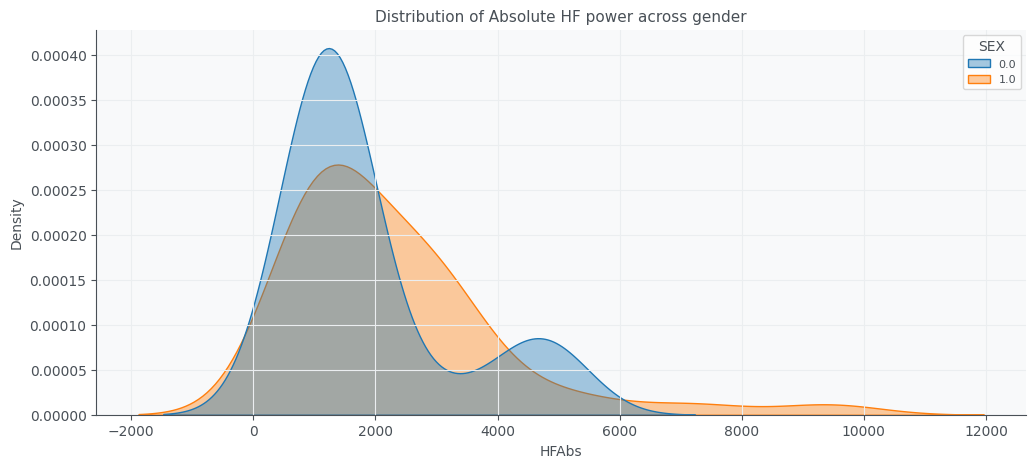

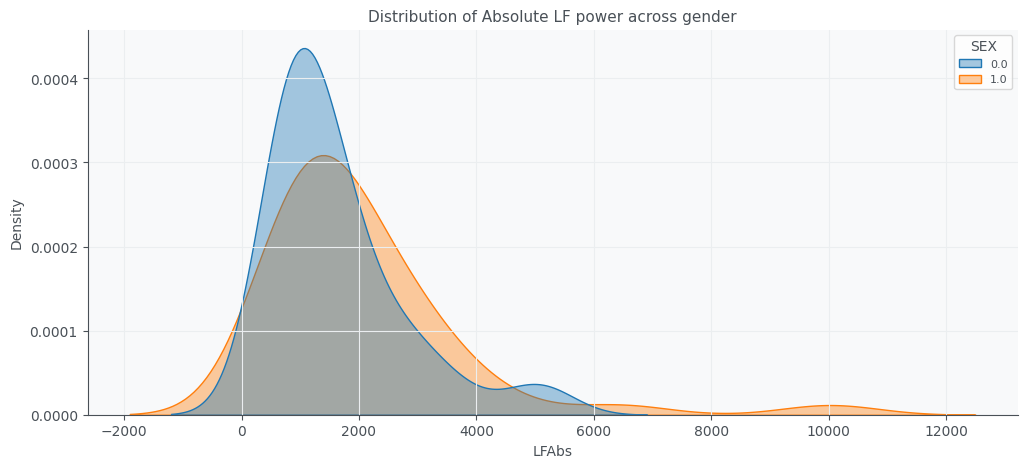

In [48]:
%matplotlib inline

# Plot
# Density plot 

# Set figure size for the notebook
plt.rcParams["figure.figsize"]=12,5


# ADHD vs clinical control
sns.kdeplot(data=Fre_df, x="HFAbs", hue="ADHD", fill=True, common_norm=False, alpha=0.4)
plt.title('Distribution of Absolute HF power for clinical controls and ADHD participants')
plt.show()

sns.kdeplot(data=Fre_df, x="LFAbs", hue="ADHD", fill=True, common_norm=False, alpha=0.4)
plt.title('Distribution of Absolute LF power for clinical controls and ADHD participants')
plt.show()


# Different age groups
sns.kdeplot(data=Fre_df, x="HFAbs", hue="AGE", fill=True, common_norm=False, alpha=0.4)
plt.title('Distribution of Absolute HF power across age groups')
plt.show()

sns.kdeplot(data=Fre_df, x="LFAbs", hue="AGE", fill=True, common_norm=False, alpha=0.4)
plt.title('Distribution of Absolute LF power across age groups')
plt.show()

# Gender 
sns.kdeplot(data=Fre_df, x="HFAbs", hue="SEX", fill=True, common_norm=False, alpha=0.4)
plt.title('Distribution of Absolute HF power across gender')
plt.show()

sns.kdeplot(data=Fre_df, x="LFAbs", hue="SEX", fill=True, common_norm=False, alpha=0.4)
plt.title('Distribution of Absolute LF power across gender')
plt.show()



In [49]:
# Scatterplots


Modelling

In [51]:
# I will be focusing on absolute, and relative power


# Models with only participant group as predictor
# Absolute power - HF / LF / VLF
mfabsHF = smf.ols(formula="HFAbs ~ ADHD", data = Fre_df).fit()
print(mfabsHF.summary())

mfabsLF = smf.ols(formula="LFAbs ~ ADHD", data = Fre_df).fit()
print(mfabsLF.summary())

mfabsVLF = smf.ols(formula="VLFAbs ~ ADHD", data = Fre_df).fit()
print(mfabsVLF.summary())


# Relative power - HF / LF 7 VLF
mfrelHF = smf.ols(formula= "HFRel ~ ADHD", data = Fre_df).fit()
print(mfrelHF.summary())

mfrelLF = smf.ols(formula= "LFRel ~ ADHD", data = Fre_df).fit()
print(mfrelLF.summary())

mfrelVLF = smf.ols(formula= "VLFRel ~ ADHD", data = Fre_df).fit()
print(mfrelVLF.summary())



# Models with sex and age included as predictors (interaction because they are interacting with each other)
# Absolute power - HF / LF / VLF
mfabsHFF = smf.ols(formula="HFAbs ~ ADHD + SEX + AGE + ADHD:SEX + ADHD:AGE + SEX:AGE", data = Fre_df).fit()
print(mfabsHFF.summary())

mfabsLFF = smf.ols(formula="LFAbs ~ ADHD + SEX + AGE + ADHD:SEX + ADHD:AGE + SEX:AGE", data = Fre_df).fit()
print(mfabsLFF.summary())

mfabsVLFF = smf.ols(formula="VLFAbs ~ ADHD + SEX + AGE + ADHD:SEX + ADHD:AGE + SEX:AGE", data = Fre_df).fit()
print(mfabsVLFF.summary())


# Relative power - HF / LF / VLF
mfrelHFF = smf.ols(formula="HFRel ~ ADHD + SEX + AGE + ADHD:SEX + ADHD:AGE + SEX:AGE", data = Fre_df).fit()
print(mfrelHFF.summary())

mfrelLFF = smf.ols(formula="LFRel ~ ADHD + SEX + AGE + ADHD:SEX + ADHD:AGE + SEX:AGE", data = Fre_df).fit()
print(mfrelLFF.summary())

mfrelVLFF = smf.ols(formula="VLFRel ~ ADHD + SEX + AGE + ADHD:SEX + ADHD:AGE + SEX:AGE", data = Fre_df).fit()
print(mfrelVLFF.summary())



                            OLS Regression Results                            
Dep. Variable:                  HFAbs   R-squared:                       0.033
Model:                            OLS   Adj. R-squared:                  0.020
Method:                 Least Squares   F-statistic:                     2.647
Date:                Thu, 11 Apr 2024   Prob (F-statistic):              0.108
Time:                        14:44:17   Log-Likelihood:                -702.37
No. Observations:                  80   AIC:                             1409.
Df Residuals:                      78   BIC:                             1414.
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                  coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------
Intercept    1806.6598    245.802      7.350      

Non-linear Methods - Poincaré plot

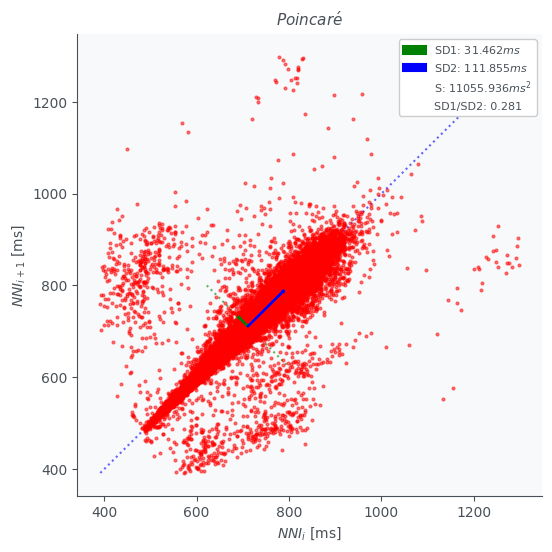

ReturnTuple(poincare_plot=<Figure size 600x600 with 1 Axes>, sd1=31.462297283036786, sd2=111.8549538604434, sd_ratio=3.5552061839028877, ellipse_area=11055.936254853408)

In [108]:
# Trying the pyHRV package
nonlinear.poincare(HRV_1_cor, ellipse=True)

Creating a function and a loop for non-linear analysis of all participants

In [109]:
# Create a function for non-linear 

def nonlin(x):
    results = nonlinear.poincare(x, ellipse=True)
    sd1 = results['sd1']
    sd2 = results['sd2']
    sdr = sd1/sd2
    ela = results['ellipse_area']
    results = [sd1, sd2, sdr, ela]
    return results



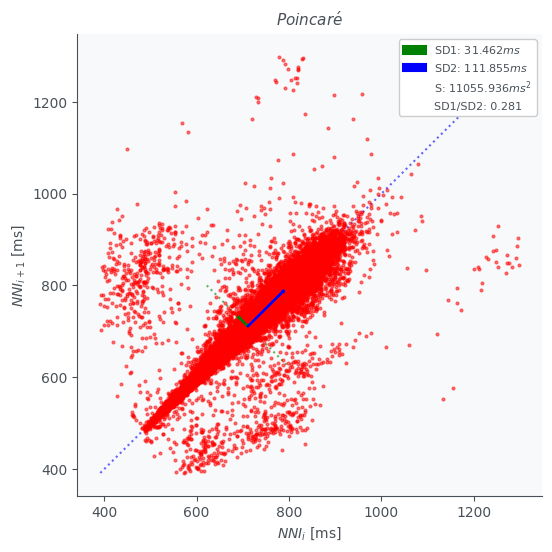

[31.462297283036786, 111.8549538604434, 0.2812776385594056, 11055.936254853408]

In [110]:
nonlin(HRV_1_cor)

In [111]:
%matplotlib agg

# Create a list object 
nonl_data = []


# Create list of datafiles

data_filesf = glob.glob("hyperaktiv/hrv_data/*.csv")

# For every file in the hrv_data folder:
for file in data_filesf:
    data = pd.read_csv(file, sep = ";", parse_dates=['TIMESTAMP'], index_col=['TIMESTAMP'])
    data = data[(data.index.hour >= 8) & (data.index.hour <= 20)]
    data['HRV'] = np.where((300 <= data['HRV']) & (data['HRV'] <= 1300), data['HRV'], np.nan)
    data['HRV'] = data['HRV'].interpolate(method='linear', axis=0).ffill().bfill()
    results = nonlin(data)
    nonl_data.append(results)




# Convert list to dataframe
nonl_df = pd.DataFrame(nonl_data)
# Print head of the dataframe
    
nonl_df.head()

c:\Users\Gacil\AppData\Local\Programs\Python\Python39\lib\site-packages\pyhrv\nonlinear.py:186: UserWarning: Matplotlib is currently using agg, which is a non-GUI backend, so cannot show the figure.
  plt.show()
c:\Users\Gacil\AppData\Local\Programs\Python\Python39\lib\site-packages\pyhrv\nonlinear.py:186: UserWarning: Matplotlib is currently using agg, which is a non-GUI backend, so cannot show the figure.
  plt.show()
c:\Users\Gacil\AppData\Local\Programs\Python\Python39\lib\site-packages\pyhrv\nonlinear.py:186: UserWarning: Matplotlib is currently using agg, which is a non-GUI backend, so cannot show the figure.
  plt.show()
c:\Users\Gacil\AppData\Local\Programs\Python\Python39\lib\site-packages\pyhrv\nonlinear.py:186: UserWarning: Matplotlib is currently using agg, which is a non-GUI backend, so cannot show the figure.
  plt.show()
c:\Users\Gacil\AppData\Local\Programs\Python\Python39\lib\site-packages\pyhrv\nonlinear.py:186: UserWarning: Matplotlib is currently using agg, which is

,0,1,2,3
0,31.462297,111.854954,0.281278,11055.936255
1,61.415260,305.042881,0.201333,58855.500916
2,33.879838,173.921762,0.194799,18511.649753
3,25.111868,141.324394,0.177690,11149.259700
4,32.245824,131.459422,0.245291,13317.265680


In [112]:
nonl_df.columns = ["SD1", "SD2", "Ratio", "S"]

nonl_df.head()

,SD1,SD2,Ratio,S
0,31.462297,111.854954,0.281278,11055.936255
1,61.415260,305.042881,0.201333,58855.500916
2,33.879838,173.921762,0.194799,18511.649753
3,25.111868,141.324394,0.177690,11149.259700
4,32.245824,131.459422,0.245291,13317.265680


In [113]:
# Add participant group, age, sex, HRV_Hours
extract = HRV_DF[["ADHD", "AGE", "SEX", "HRV_HOURS"]]

extract = extract.reset_index(drop=True)

nonl_df = extract.join(nonl_df)
nonl_df.head()


    ADHD  AGE  SEX  HRV_HOURS
0      1    3    0       21.0
1      1    2    1       21.0
2      1    3    1       22.0
3      1    1    1       12.0
4      0    3    0       21.0
..   ...  ...  ...        ...
75     1    3    0       17.0
76     0    1    1       21.0
77     0    4    1       22.0
78     0    2    0       22.0
79     0    4    1       13.0

[80 rows x 4 columns]


,ADHD,AGE,SEX,HRV_HOURS,SD1,SD2,Ratio,S
0,1,3,0,21.0,31.462297,111.854954,0.281278,11055.936255
1,1,2,1,21.0,61.415260,305.042881,0.201333,58855.500916
2,1,3,1,22.0,33.879838,173.921762,0.194799,18511.649753
3,1,1,1,12.0,25.111868,141.324394,0.177690,11149.259700
4,0,3,0,21.0,32.245824,131.459422,0.245291,13317.265680


In [117]:
nonl_df["HRV_HOURS"] = nonl_df["HRV_HOURS"].astype("category")

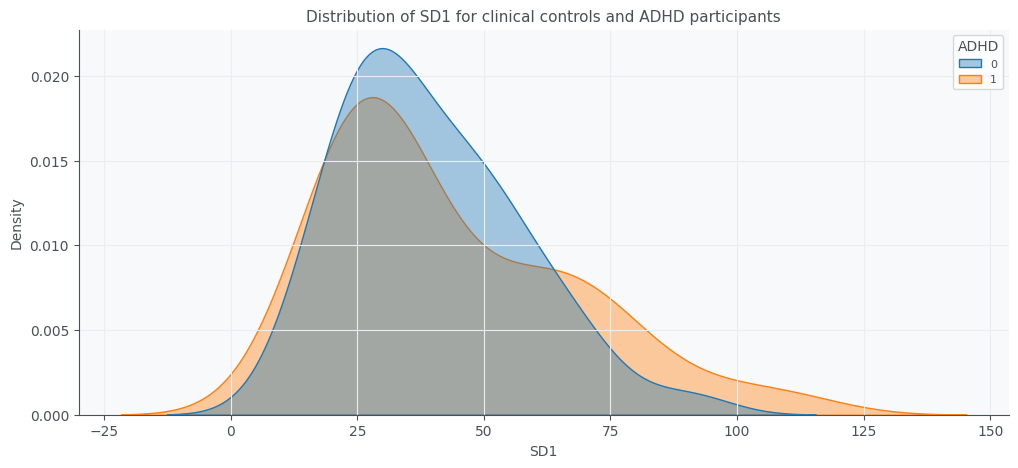

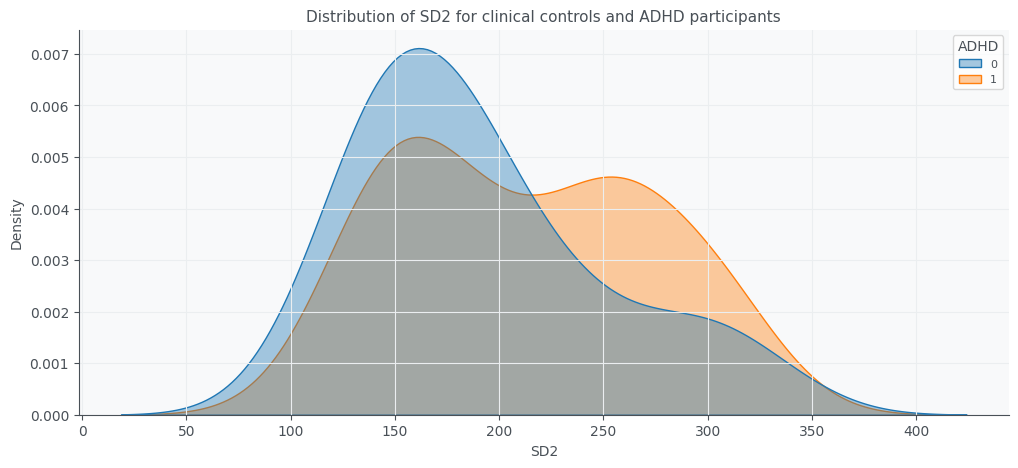

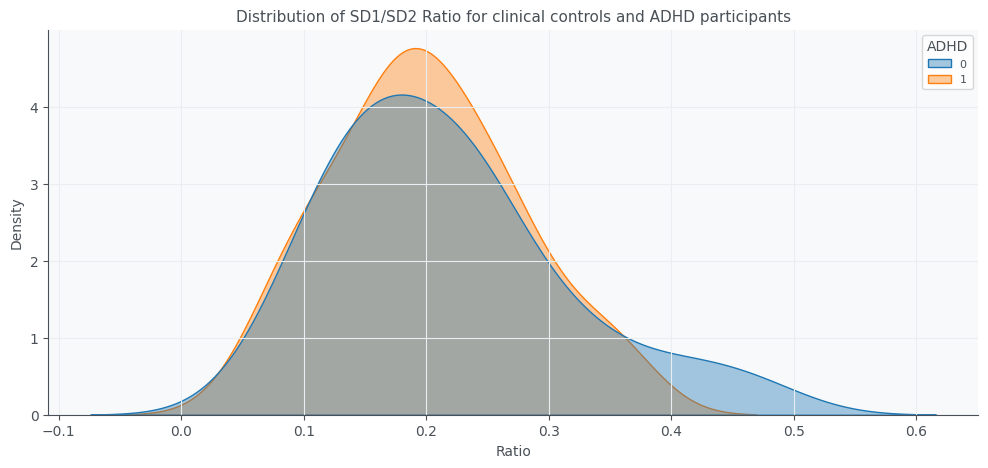

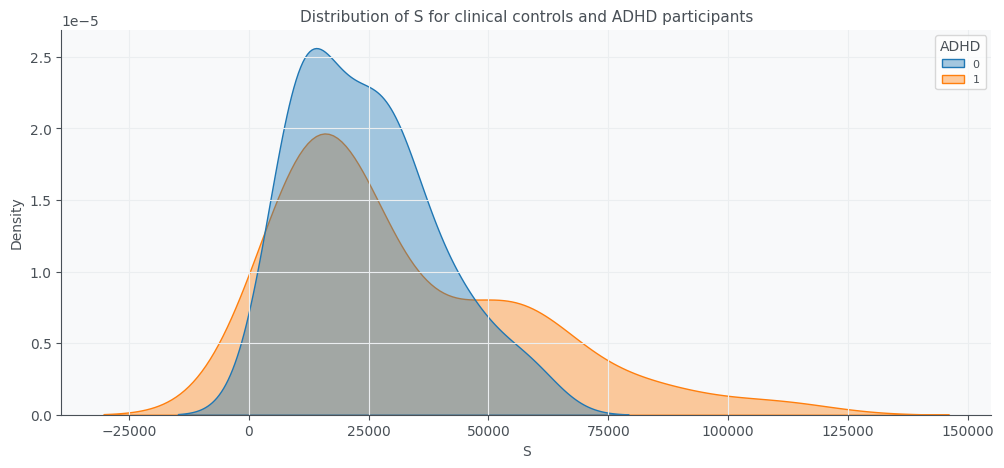

In [120]:
%matplotlib inline
# Visualize
# Set figure size for the notebook
plt.rcParams["figure.figsize"]=12,5


# ADHD vs clinical control
sns.kdeplot(data=nonl_df, x="SD1", hue="ADHD", fill=True, common_norm=False, alpha=0.4)
plt.title('Distribution of SD1 for clinical controls and ADHD participants')
plt.show()

sns.kdeplot(data=nonl_df, x="SD2", hue="ADHD", fill=True, common_norm=False, alpha=0.4)
plt.title('Distribution of SD2 for clinical controls and ADHD participants')
plt.show()

sns.kdeplot(data=nonl_df, x="Ratio", hue="ADHD", fill=True, common_norm=False, alpha=0.4)
plt.title('Distribution of SD1/SD2 Ratio for clinical controls and ADHD participants')
plt.show()

sns.kdeplot(data=nonl_df, x="S", hue="ADHD", fill=True, common_norm=False, alpha=0.4)
plt.title('Distribution of S for clinical controls and ADHD participants')
plt.show()



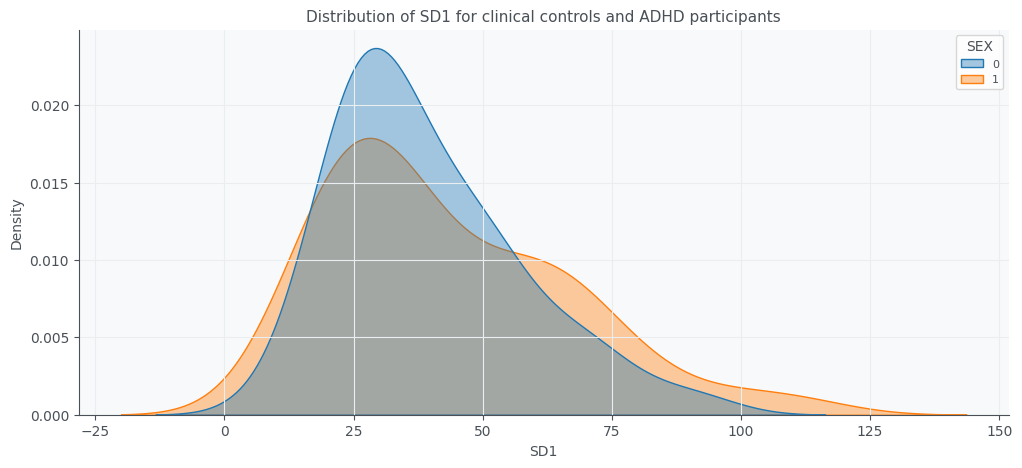

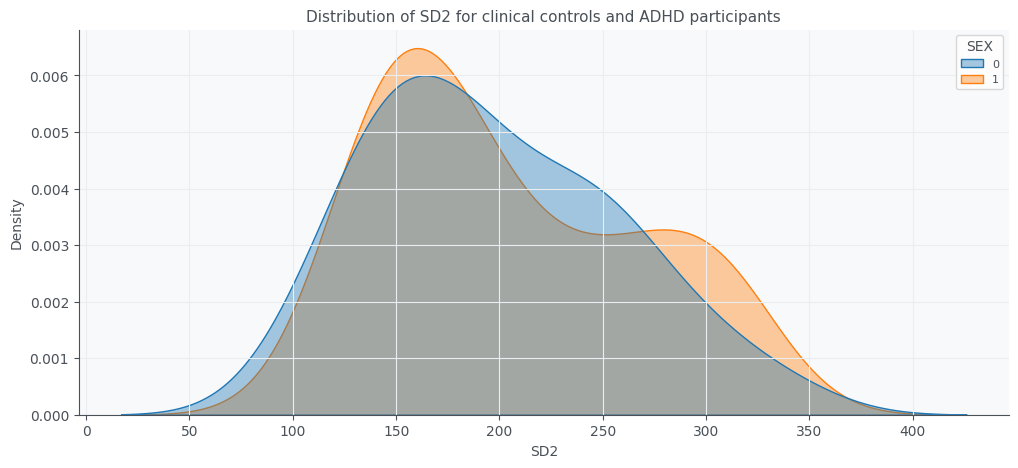

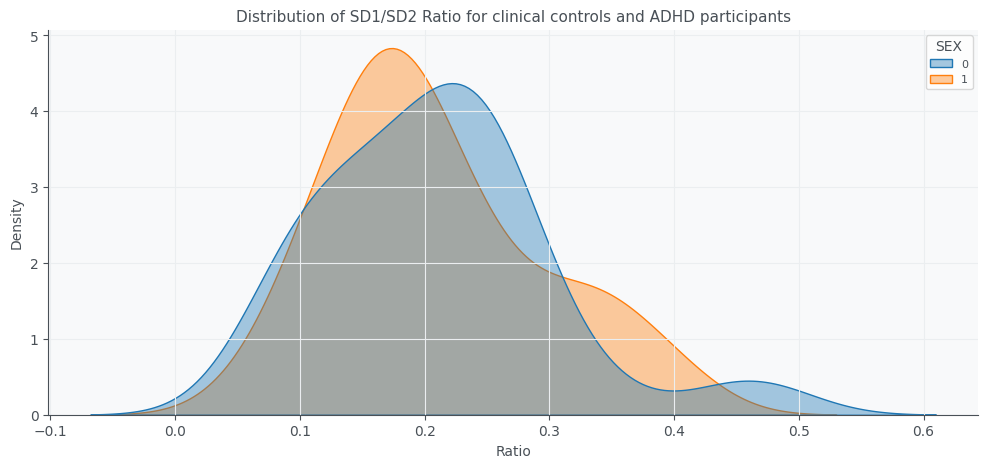

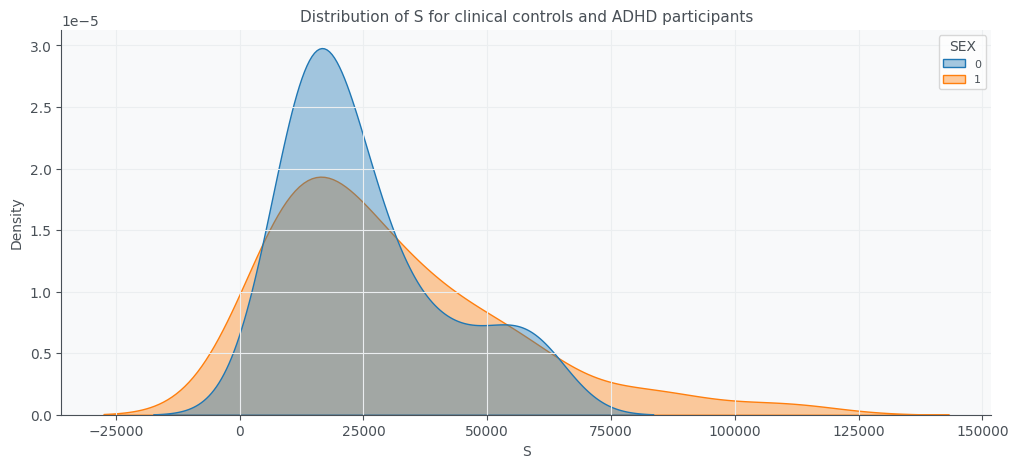

In [121]:
# SEX
sns.kdeplot(data=nonl_df, x="SD1", hue="SEX", fill=True, common_norm=False, alpha=0.4)
plt.title('Distribution of SD1 for clinical controls and ADHD participants')
plt.show()

sns.kdeplot(data=nonl_df, x="SD2", hue="SEX", fill=True, common_norm=False, alpha=0.4)
plt.title('Distribution of SD2 for clinical controls and ADHD participants')
plt.show()

sns.kdeplot(data=nonl_df, x="Ratio", hue="SEX", fill=True, common_norm=False, alpha=0.4)
plt.title('Distribution of SD1/SD2 Ratio for clinical controls and ADHD participants')
plt.show()

sns.kdeplot(data=nonl_df, x="S", hue="SEX", fill=True, common_norm=False, alpha=0.4)
plt.title('Distribution of S for clinical controls and ADHD participants')
plt.show()


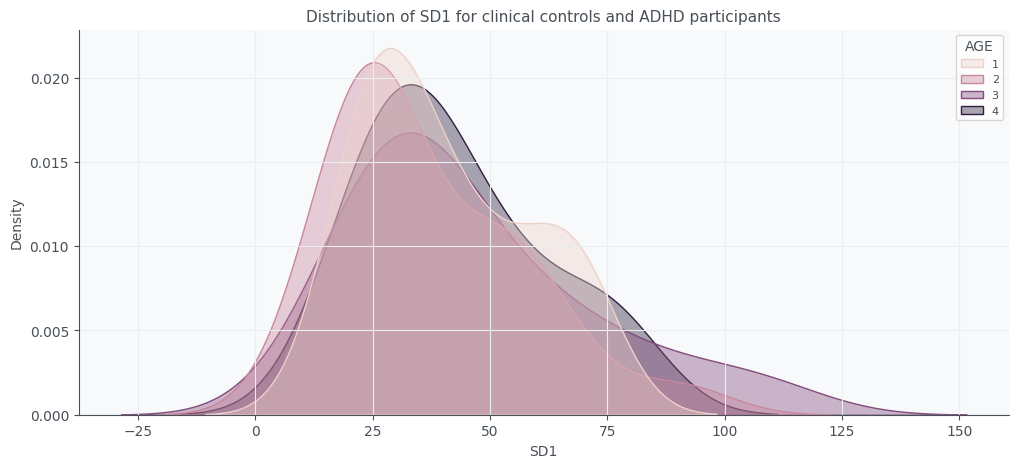

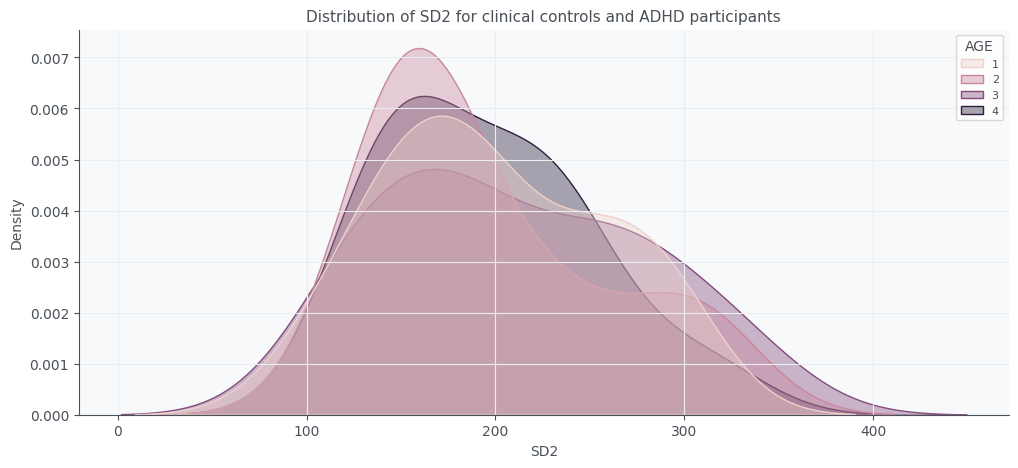

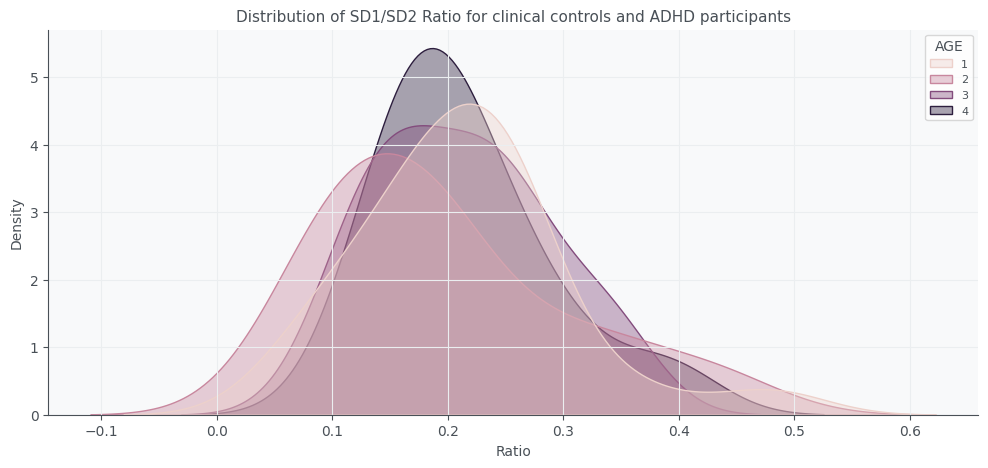

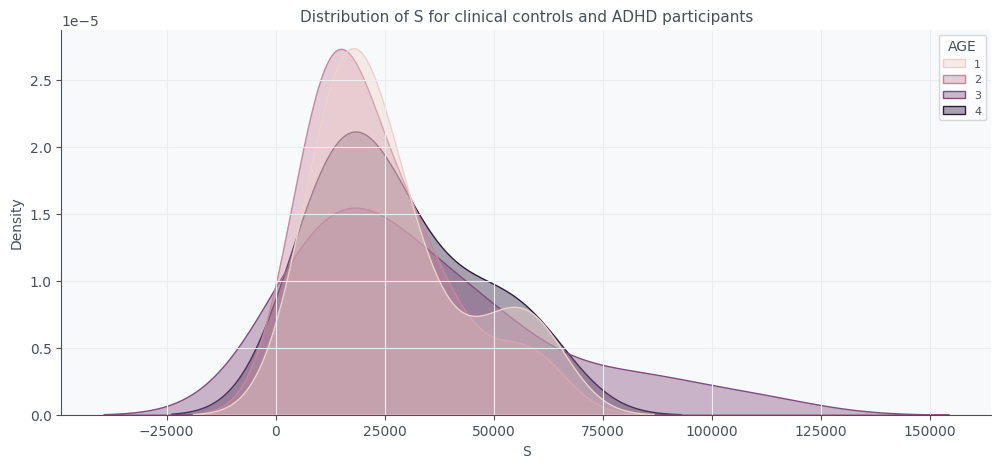

In [122]:
# AGE GROUPS
sns.kdeplot(data=nonl_df, x="SD1", hue="AGE", fill=True, common_norm=False, alpha=0.4)
plt.title('Distribution of SD1 for clinical controls and ADHD participants')
plt.show()

sns.kdeplot(data=nonl_df, x="SD2", hue="AGE", fill=True, common_norm=False, alpha=0.4)
plt.title('Distribution of SD2 for clinical controls and ADHD participants')
plt.show()

sns.kdeplot(data=nonl_df, x="Ratio", hue="AGE", fill=True, common_norm=False, alpha=0.4)
plt.title('Distribution of SD1/SD2 Ratio for clinical controls and ADHD participants')
plt.show()

sns.kdeplot(data=nonl_df, x="S", hue="AGE", fill=True, common_norm=False, alpha=0.4)
plt.title('Distribution of S for clinical controls and ADHD participants')
plt.show()

Modelling

In [123]:
# Modelling

# Models with only participant group as predictor
msd1 = smf.ols(formula="SD1 ~ ADHD", data = nonl_df).fit()
print(msd1.summary())

msd2 = smf.ols(formula= "SD2 ~ ADHD", data = nonl_df).fit()
print(msd2.summary())

ms = smf.ols(formula= "S ~ ADHD", data = nonl_df).fit()
print(ms.summary())


# Models with sex and age included as predictors (interaction because they are interacting with each other)
msd1_f = smf.ols(formula="SD1 ~ ADHD + SEX + AGE + ADHD:SEX + ADHD:AGE + SEX:AGE", data = nonl_df).fit()
print(msd1_f.summary())

msd2_f = smf.ols(formula="SD2 ~ ADHD + SEX + AGE + ADHD:SEX + ADHD:AGE + SEX:AGE", data = nonl_df).fit()
print(msd2_f.summary())

ms_f = smf.ols(formula="S ~ ADHD + SEX + AGE + ADHD:SEX + ADHD:AGE + SEX:AGE", data = nonl_df).fit()
print(ms_f.summary())


                            OLS Regression Results                            
Dep. Variable:                    SD1   R-squared:                       0.008
Model:                            OLS   Adj. R-squared:                 -0.005
Method:                 Least Squares   F-statistic:                    0.6446
Date:                Thu, 11 Apr 2024   Prob (F-statistic):              0.424
Time:                        10:17:08   Log-Likelihood:                -355.73
No. Observations:                  80   AIC:                             715.5
Df Residuals:                      78   BIC:                             720.2
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept     39.5655      3.227     12.261      0.0